In [49]:
%matplotlib notebook
import dill
import glob
from plumbum import local
import matplotlib
from matplotlib import pyplot
import numpy
import os
import pandas
from scipy import stats
from scipy.spatial import distance
from scipy.cluster import hierarchy
import seaborn

In [2]:
wc, bedtools = local['wc'], local['bedtools']

# START HERE 20200304

In [4]:
#peaks_merge = ('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
#               'all_lda1_peaks.scored_filtered_merged_colored.tissue_merged.overlaps_merged_for_lda.bed')
peaks_merge = ('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
               'topic_analysis/rank_peaks/topic_analysis/test_merge_and_expand/all_summits_expanded2.merged.expanded2.bed')

In [5]:
tf_beds = glob.glob('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
                    'WS245/annotatedPeak.20190420.*.merged.bed')
tf_types = []
sci_tfs_by_stage = []
tfs_by_stage_sci = []
tfs_by_stage_total = []
sci_total = int(wc('-l', peaks_merge).strip().split()[0])
for tf_bed in tf_beds:
    tf_type = os.path.basename(tf_bed).split('.')[-3]
    print(tf_type)
    cmd = bedtools['intersect', '-u', '-a', peaks_merge, '-b', tf_bed] | wc['-l']
    sci_tfs_by_stage.append((int(cmd().strip()), sci_total))
    print('ATAC peaks overlapping TF peaks: {!s}/{!s} ({!s}%)'.format(sci_tfs_by_stage[-1][0],
                                                                        sci_tfs_by_stage[-1][1],
                                                                        round(numpy.divide(*sci_tfs_by_stage[-1])*100,2)))

    tfs_by_stage_total.append(int(wc('-l', tf_bed).strip().split()[0]))
    cmd = bedtools['intersect', '-u', '-b', peaks_merge, '-a', tf_bed] | wc['-l']
    tfs_by_stage_sci.append((int(cmd().strip()), tfs_by_stage_total[-1]))
    print('TF peaks overlapping ATAC peaks: {!s}/{!s} ({!s}%)\n'.format(tfs_by_stage_sci[-1][0],
                                                                          tfs_by_stage_sci[-1][1],
                                                                          round(numpy.divide(*tfs_by_stage_sci[-1])*100,2)))

dauer
ATAC peaks overlapping TF peaks: 77/38017 (0.2%)
TF peaks overlapping ATAC peaks: 74/91 (81.32%)

early_embryonic
ATAC peaks overlapping TF peaks: 4377/38017 (11.51%)
TF peaks overlapping ATAC peaks: 3685/4693 (78.52%)

L1_larva
ATAC peaks overlapping TF peaks: 22626/38017 (59.52%)
TF peaks overlapping ATAC peaks: 19458/24875 (78.22%)

L2_larva
ATAC peaks overlapping TF peaks: 17835/38017 (46.91%)
TF peaks overlapping ATAC peaks: 15492/17768 (87.19%)

L3_larva
ATAC peaks overlapping TF peaks: 19641/38017 (51.66%)
TF peaks overlapping ATAC peaks: 17052/21462 (79.45%)

L4_larva
ATAC peaks overlapping TF peaks: 19018/38017 (50.02%)
TF peaks overlapping ATAC peaks: 15989/20304 (78.75%)

L4_young_adult
ATAC peaks overlapping TF peaks: 3687/38017 (9.7%)
TF peaks overlapping ATAC peaks: 3244/3357 (96.63%)

late_embryonic
ATAC peaks overlapping TF peaks: 12591/38017 (33.12%)
TF peaks overlapping ATAC peaks: 10504/13858 (75.8%)

midembryonic
ATAC peaks overlapping TF peaks: 2074/38017 (5.

In [40]:
tf_beds = [elt for elt in glob.glob('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
                                    'WS245/annotatedPeak.20190420.*.merged.bed')
           if 'all' not in elt 
           and 'non-L2' not in elt 
           and 'L4_young_adult' not in elt 
           and 'dauer' not in elt
           and 'midembryonic' not in elt
           and 'hlh-1' not in elt
           and 'elt-1' not in elt
           and 'elt-2' not in elt]
tf_beds_unique = []

#make unique lists of peaks for each dev stage
tf_beds_counts = []
unique_tf_beds_counts = []
for idx in range(len(tf_beds)):
    out_file = os.path.splitext(tf_beds[idx])[0] + '.unique.bed'
    unique_cmd = bedtools.__getitem__(['intersect', '-v', '-a', tf_beds[idx], '-b'] + 
                                      [elt for elt_idx, elt in enumerate(tf_beds) if elt_idx != idx]) > out_file
    unique_cmd()
    unique_count = int(wc('-l', out_file).split()[0])
    tf_beds_counts.append(int(wc('-l', tf_beds[idx]).split()[0]))
    tf_beds_unique.append(out_file)
    unique_tf_beds_counts.append(unique_count)
    print('{!s}\t{!s} of {!s} ({!s}%)'.format(os.path.basename(tf_beds[idx]), 
                                              unique_tf_beds_counts[idx], 
                                              tf_beds_counts[idx],
                                              round((unique_tf_beds_counts[idx]/tf_beds_counts[idx])*100,2)))

annotatedPeak.20190420.early_embryonic.merged.bed	438 of 4693 (9.33%)
annotatedPeak.20190420.L1_larva.merged.bed	4381 of 24875 (17.61%)
annotatedPeak.20190420.L2_larva.merged.bed	751 of 17768 (4.23%)
annotatedPeak.20190420.L3_larva.merged.bed	1641 of 21462 (7.65%)
annotatedPeak.20190420.L4_larva.merged.bed	1378 of 20304 (6.79%)
annotatedPeak.20190420.late_embryonic.merged.bed	944 of 13858 (6.81%)
annotatedPeak.20190420.mixed_stage_embryonic.merged.bed	2752 of 15372 (17.9%)
annotatedPeak.20190420.young_adult.merged.bed	4069 of 17966 (22.65%)


In [7]:
tf_beds = tf_beds_unique
tf_types = []
sci_uniq_tfs_by_stage = []
uniq_tfs_by_stage_sci = []
uniq_tfs_by_stage_total = []
sci_total = int(wc('-l', peaks_merge).strip().split()[0])
for tf_bed in tf_beds:
    tf_type = os.path.basename(tf_bed).split('.')[-4]
    print(tf_type)
    cmd = bedtools['intersect', '-u', '-a', peaks_merge, '-b', tf_bed] | wc['-l']
    sci_uniq_tfs_by_stage.append((int(cmd().strip()), sci_total))
    print('ATAC summits overlapping TF peaks: {!s}/{!s} ({!s}%)'.format(sci_uniq_tfs_by_stage[-1][0],
                                                                        sci_uniq_tfs_by_stage[-1][1],
                                                                        round(numpy.divide(*sci_uniq_tfs_by_stage[-1])*100,2)))

    uniq_tfs_by_stage_total.append(int(wc('-l', tf_bed).strip().split()[0]))
    cmd = bedtools['intersect', '-u', '-b', peaks_merge, '-a', tf_bed] | wc['-l']
    uniq_tfs_by_stage_sci.append((int(cmd().strip()), uniq_tfs_by_stage_total[-1]))
    print('TF peaks overlapping ATAC summits: {!s}/{!s} ({!s}%)\n'.format(uniq_tfs_by_stage_sci[-1][0],
                                                                          uniq_tfs_by_stage_sci[-1][1],
                                                                          round(numpy.divide(*uniq_tfs_by_stage_sci[-1])*100,2)))

early_embryonic
ATAC summits overlapping TF peaks: 102/38017 (0.27%)
TF peaks overlapping ATAC summits: 82/438 (18.72%)

L1_larva
ATAC summits overlapping TF peaks: 2128/38017 (5.6%)
TF peaks overlapping ATAC summits: 1863/4381 (42.52%)

L2_larva
ATAC summits overlapping TF peaks: 373/38017 (0.98%)
TF peaks overlapping ATAC summits: 319/751 (42.48%)

L3_larva
ATAC summits overlapping TF peaks: 836/38017 (2.2%)
TF peaks overlapping ATAC summits: 694/1641 (42.29%)

L4_larva
ATAC summits overlapping TF peaks: 599/38017 (1.58%)
TF peaks overlapping ATAC summits: 485/1378 (35.2%)

late_embryonic
ATAC summits overlapping TF peaks: 207/38017 (0.54%)
TF peaks overlapping ATAC summits: 174/944 (18.43%)

mixed_stage_embryonic
ATAC summits overlapping TF peaks: 639/38017 (1.68%)
TF peaks overlapping ATAC summits: 559/2752 (20.31%)

young_adult
ATAC summits overlapping TF peaks: 840/38017 (2.21%)
TF peaks overlapping ATAC summits: 695/4069 (17.08%)



<IPython.core.display.Javascript object>


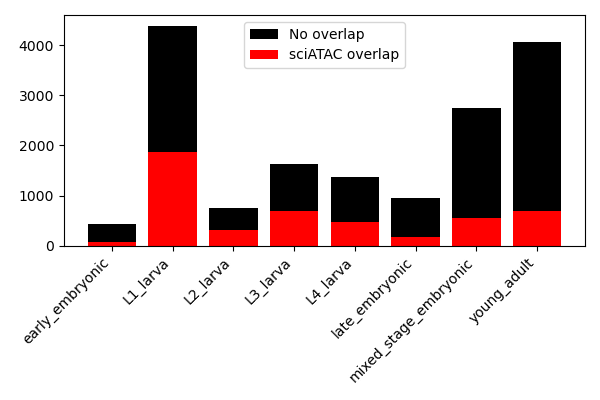

In [8]:
uniq_tfs_by_stage_sci_arr = numpy.array(uniq_tfs_by_stage_sci)[:,0]
non_overlap = numpy.array(uniq_tfs_by_stage_total) - uniq_tfs_by_stage_sci_arr

xlocs = numpy.arange(non_overlap.shape[0])
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4))
axes.bar(xlocs, non_overlap, bottom=uniq_tfs_by_stage_sci_arr, color='k', label="No overlap")
axes.bar(xlocs, uniq_tfs_by_stage_sci_arr, color='r', label='sciATAC overlap')
axes.set_xticks(xlocs)
axes.set_xticklabels([os.path.basename(elt).split('.')[-4] for elt in tf_beds_unique], ha='right', rotation=45)
axes.legend(loc='best')
fig.tight_layout()

<IPython.core.display.Javascript object>


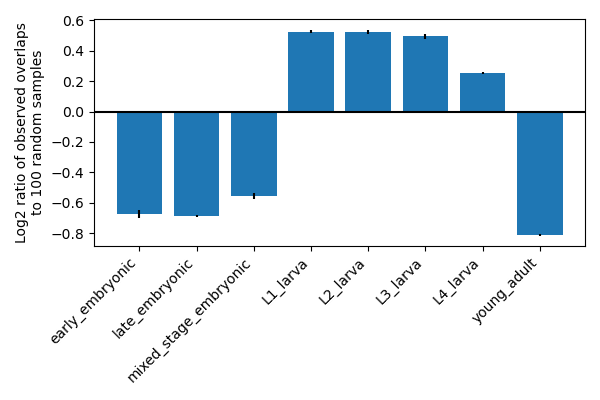

In [9]:
uniq_tfs_by_stage_sci_arr = numpy.array(uniq_tfs_by_stage_sci)[:,0]
uniq_tfs_by_stage_total_arr = numpy.array(uniq_tfs_by_stage_sci)[:,1]
non_overlap = uniq_tfs_by_stage_total_arr - uniq_tfs_by_stage_sci_arr

samples = numpy.random.choice(numpy.arange(uniq_tfs_by_stage_sci_arr.shape[0]), 
                              size=(100, numpy.sum(uniq_tfs_by_stage_sci_arr)),
                              replace=True,
                              p=uniq_tfs_by_stage_total_arr/numpy.sum(uniq_tfs_by_stage_total_arr))
samples = numpy.hstack([numpy.sum(samples == elt, axis=1)[:,None] 
                        for elt in range(uniq_tfs_by_stage_sci_arr.shape[0])])

ratios = numpy.log2((uniq_tfs_by_stage_sci_arr/samples))
mean_ratio = numpy.mean(ratios, axis=0)

ratios_sem = stats.sem(ratios, axis=0)
conf_int = numpy.array([stats.t.interval(0.95, ratios.shape[0]-1, 
                                         loc=mean_ratio[idx], scale=ratios_sem[idx])
                        for idx in range(ratios.shape[1])]).T
conf_int[0] = mean_ratio - conf_int[0]
conf_int[1] = conf_int[1] - mean_ratio

reorder = [0,5,6,1,2,3,4,7]
xlocs = numpy.arange(non_overlap.shape[0])
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4))
axes.bar(xlocs, mean_ratio[reorder], yerr=conf_int)
axes.axhline(0,color='k')
axes.set_xticks(xlocs)
axes.set_xticklabels(numpy.array([os.path.basename(elt).split('.')[-4] 
                                  for elt in tf_beds_unique])[reorder], ha='right', rotation=45)
axes.set_ylabel('Log2 ratio of observed overlaps\nto 100 random samples')
fig.tight_layout()

<IPython.core.display.Javascript object>


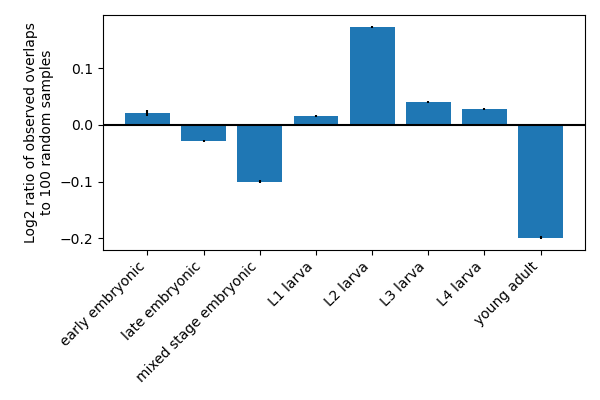

In [10]:
to_use = [1,7,9,2,3,4,5,10]
tfs_by_stage_sci_arr = numpy.array(tfs_by_stage_sci)[to_use,0]
tfs_by_stage_total_arr = numpy.array(tfs_by_stage_sci)[to_use,1]
non_overlap = tfs_by_stage_total_arr - tfs_by_stage_sci_arr

samples = numpy.random.choice(numpy.arange(tfs_by_stage_sci_arr.shape[0]), 
                              size=(100, numpy.sum(tfs_by_stage_sci_arr)),
                              replace=True,
                              p=tfs_by_stage_total_arr/numpy.sum(tfs_by_stage_total_arr))
samples = numpy.hstack([numpy.sum(samples == elt, axis=1)[:,None] 
                        for elt in range(tfs_by_stage_sci_arr.shape[0])])

ratios = numpy.log2((tfs_by_stage_sci_arr/samples))
mean_ratio = numpy.mean(ratios, axis=0)

ratios_sem = stats.sem(ratios, axis=0)
conf_int = numpy.array([stats.t.interval(0.95, ratios.shape[0]-1, 
                                         loc=mean_ratio[idx], scale=ratios_sem[idx])
                        for idx in range(ratios.shape[1])]).T
conf_int[0] = mean_ratio - conf_int[0]
conf_int[1] = conf_int[1] - mean_ratio

reorder = [0,5,6,1,2,3,4,7]
xlocs = numpy.arange(non_overlap.shape[0])
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4))
axes.bar(xlocs, mean_ratio, yerr=conf_int)
axes.axhline(0,color='k')
axes.set_xticks(xlocs)
axes.set_xticklabels(numpy.array([os.path.basename(elt).split('.')[-4].replace('_', ' ') 
                                  for elt in tf_beds_unique])[reorder], ha='right', rotation=45)
axes.set_ylabel('Log2 ratio of observed overlaps\nto 100 random samples')
fig.tight_layout()

## Look at overlaps by stage for singleton ChIP sites

In [94]:
tf_beds = glob.glob('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
                    'WS245/annotatedPeak.20190420.*.merged.bed')
singleton_sites = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
                   'WS245/PeakClusters.20190420.mean_loc_tf_count.eq1.bed')
tf_types = []
sci_tfs_by_stage = []
tfs_by_stage_sci = []
tfs_by_stage_total = []
sci_total = int(wc('-l', peaks_merge).strip().split()[0])
for tf_bed in tf_beds:
    tf_type = os.path.basename(tf_bed).split('.')[-3]
    print(tf_type)
    cmd = (bedtools['intersect', '-u', '-a', tf_bed, '-b', singleton_sites]
           | bedtools['intersect', '-u', '-a', peaks_merge, '-b', 'stdin'] 
           | wc['-l'])
    sci_tfs_by_stage.append((int(cmd().strip()), sci_total))
    print('ATAC peaks overlapping singleton TF peaks: {!s}/{!s} ({!s}%)'.format(sci_tfs_by_stage[-1][0],
                                                                        sci_tfs_by_stage[-1][1],
                                                                        round(numpy.divide(*sci_tfs_by_stage[-1])*100,2)))

    tfs_by_stage_cmd = bedtools['intersect', '-u', '-a', tf_bed, '-b', singleton_sites] | wc['-l']
    tfs_by_stage_total.append(int(tfs_by_stage_cmd().strip().split()[0]))
    cmd = (bedtools['intersect', '-u', '-a', tf_bed, '-b', singleton_sites] 
           | bedtools['intersect', '-u', '-b', peaks_merge, '-a', 'stdin'] 
           | wc['-l'])
    tfs_by_stage_sci.append((int(cmd().strip()), tfs_by_stage_total[-1]))
    print('Singleton TF peaks overlapping ATAC peaks: {!s}/{!s} ({!s}%)\n'.format(tfs_by_stage_sci[-1][0],
                                                                          tfs_by_stage_sci[-1][1],
                                                                          round(numpy.divide(*tfs_by_stage_sci[-1])*100,2)))

dauer
ATAC peaks overlapping singleton TF peaks: 5/38017 (0.01%)
Singleton TF peaks overlapping ATAC peaks: 5/5 (100.0%)

early_embryonic
ATAC peaks overlapping singleton TF peaks: 1519/38017 (4.0%)
Singleton TF peaks overlapping ATAC peaks: 1219/1898 (64.23%)

L1_larva
ATAC peaks overlapping singleton TF peaks: 9622/38017 (25.31%)
Singleton TF peaks overlapping ATAC peaks: 7540/10637 (70.88%)

L2_larva
ATAC peaks overlapping singleton TF peaks: 5974/38017 (15.71%)
Singleton TF peaks overlapping ATAC peaks: 4704/5633 (83.51%)

L3_larva
ATAC peaks overlapping singleton TF peaks: 7640/38017 (20.1%)
Singleton TF peaks overlapping ATAC peaks: 6020/8565 (70.29%)

L4_larva
ATAC peaks overlapping singleton TF peaks: 7576/38017 (19.93%)
Singleton TF peaks overlapping ATAC peaks: 5702/7919 (72.0%)

L4_young_adult
ATAC peaks overlapping singleton TF peaks: 749/38017 (1.97%)
Singleton TF peaks overlapping ATAC peaks: 631/662 (95.32%)

late_embryonic
ATAC peaks overlapping singleton TF peaks: 4536

<IPython.core.display.Javascript object>


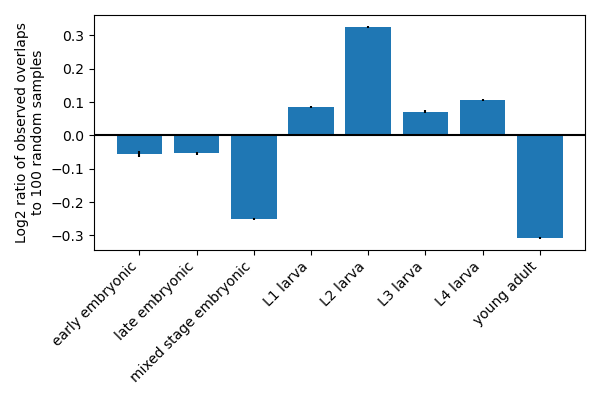

In [95]:
to_use = [1,7,9,2,3,4,5,10]
tfs_by_stage_sci_arr = numpy.array(tfs_by_stage_sci)[to_use,0]
tfs_by_stage_total_arr = numpy.array(tfs_by_stage_sci)[to_use,1]
non_overlap = tfs_by_stage_total_arr - tfs_by_stage_sci_arr

samples = numpy.random.choice(numpy.arange(tfs_by_stage_sci_arr.shape[0]), 
                              size=(100, numpy.sum(tfs_by_stage_sci_arr)),
                              replace=True,
                              p=tfs_by_stage_total_arr/numpy.sum(tfs_by_stage_total_arr))
samples = numpy.hstack([numpy.sum(samples == elt, axis=1)[:,None] 
                        for elt in range(tfs_by_stage_sci_arr.shape[0])])

ratios = numpy.log2((tfs_by_stage_sci_arr/samples))
mean_ratio = numpy.mean(ratios, axis=0)

ratios_sem = stats.sem(ratios, axis=0)
conf_int = numpy.array([stats.t.interval(0.95, ratios.shape[0]-1, 
                                         loc=mean_ratio[idx], scale=ratios_sem[idx])
                        for idx in range(ratios.shape[1])]).T
conf_int[0] = mean_ratio - conf_int[0]
conf_int[1] = conf_int[1] - mean_ratio

reorder = [0,5,6,1,2,3,4,7]
xlocs = numpy.arange(non_overlap.shape[0])
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4))
axes.bar(xlocs, mean_ratio, yerr=conf_int)
axes.axhline(0,color='k')
axes.set_xticks(xlocs)
axes.set_xticklabels(numpy.array([os.path.basename(elt).split('.')[-4].replace('_', ' ') 
                                  for elt in tf_beds_unique])[reorder], ha='right', rotation=45)
axes.set_ylabel('Log2 ratio of observed overlaps\nto 100 random samples')
fig.tight_layout()

In [98]:
non_overlap_total = numpy.sum(non_overlap)
#what frac of non_overlaps are L2?
print('L2 singleton non-overlaps: {!s} out of {!s} ({:0.2f}%)'.format(non_overlap[4],
                                                                      non_overlap_total,
                                                                      (non_overlap[4]/non_overlap_total) * 100))

L2 singleton non-overlaps: 929 out of 18543 (5.01%)


## Overlaps by TF and LDA topic

In [11]:
summits = {int(os.path.basename(os.path.dirname(elt))):elt 
           for elt in glob.glob('../topic_analysis/rank_peaks/topic_analysis/*/*_expanded2.bed')}
topics_for_clustering = sorted([0,1,10,12,13,14,15,16,17,18,19,21,23,24,25,27,30,31,
                                32,33,35,36,37,38,4,40,41,43,45,46,47,48,51,53,6,7,9])
hlh1_none_tfc = []
hlh1_overlap_tfc = []
hlh1_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
            'WS245/annotatedPeak.20190420.hlh-1.merged.bed')
hotsite_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
               'WS245/PeakClusters.20190420.mean_loc_tf_count.ge40.bed')
for idx in topics_for_clustering:
    topic_total = int(wc('-l', summits[idx]).split()[0])
    
    out_file = os.path.splitext(summits[idx])[0] + '.hlh-1_none.bed'
    hlh1_none_cmd = (bedtools['intersect', '-v', '-a', hlh1_bed, '-b', hotsite_bed] 
                     | bedtools['intersect', '-v', '-a', summits[idx], '-b', 'stdin'] > out_file)
    hlh1_none_cmd()
    hlh1_none_tfc.append((int(wc('-l', out_file).split()[0]), topic_total))

    out_file = os.path.splitext(summits[idx])[0] + '.hlh-1_overlap.bed'
    hlh1_overlap_cmd = (bedtools['intersect', '-v', '-a', hlh1_bed, '-b', hotsite_bed] 
                        | bedtools['intersect', '-wa', '-a', summits[idx], '-b', 'stdin'] > out_file)
    hlh1_overlap_cmd()
    hlh1_overlap_tfc.append((int(wc('-l', out_file).split()[0]), topic_total))

    print('{!s}:\tnone:{!s}\toverlaps:{!s}\t({!s}% overlapping)'.format(summits[idx], 
                                                                        hlh1_none_tfc[-1][0], 
                                                                        hlh1_overlap_tfc[-1][0],
                                                                        round(numpy.divide(*hlh1_overlap_tfc[-1])*100,2)))

../topic_analysis/rank_peaks/topic_analysis/0/0_summits_expanded2.bed:	none:8068	overlaps:214	(2.58% overlapping)
../topic_analysis/rank_peaks/topic_analysis/1/1_summits_expanded2.bed:	none:14697	overlaps:300	(2.0% overlapping)
../topic_analysis/rank_peaks/topic_analysis/4/4_summits_expanded2.bed:	none:7121	overlaps:346	(4.63% overlapping)
../topic_analysis/rank_peaks/topic_analysis/6/6_summits_expanded2.bed:	none:10312	overlaps:188	(1.79% overlapping)
../topic_analysis/rank_peaks/topic_analysis/7/7_summits_expanded2.bed:	none:1409	overlaps:36	(2.49% overlapping)
../topic_analysis/rank_peaks/topic_analysis/9/9_summits_expanded2.bed:	none:4843	overlaps:91	(1.84% overlapping)
../topic_analysis/rank_peaks/topic_analysis/10/10_summits_expanded2.bed:	none:7737	overlaps:201	(2.53% overlapping)
../topic_analysis/rank_peaks/topic_analysis/12/12_summits_expanded2.bed:	none:6516	overlaps:167	(2.5% overlapping)
../topic_analysis/rank_peaks/topic_analysis/13/13_summits_expanded2.bed:	none:6557	ove

<IPython.core.display.Javascript object>


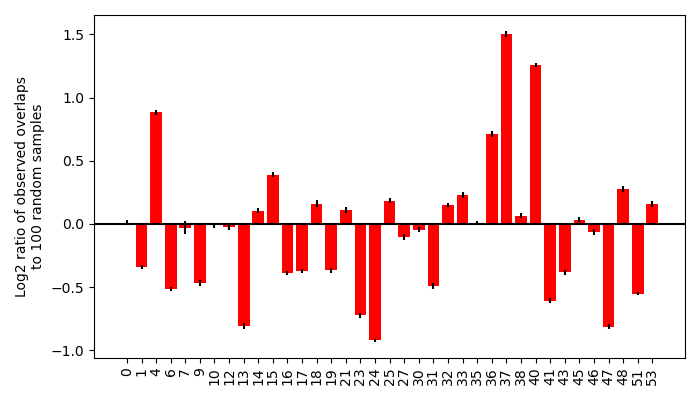

In [12]:
hlh1_overlap_arr = numpy.array(hlh1_overlap_tfc)[:,0]
hlh1_total_arr = numpy.array(hlh1_overlap_tfc)[:,1]
non_overlap = hlh1_total_arr - hlh1_overlap_arr

samples = numpy.random.choice(numpy.arange(hlh1_overlap_arr.shape[0]), 
                              size=(100, numpy.sum(hlh1_overlap_arr)),
                              replace=True,
                              p=hlh1_total_arr/numpy.sum(hlh1_total_arr))
samples = numpy.hstack([numpy.sum(samples == elt, axis=1)[:,None] 
                        for elt in range(hlh1_overlap_arr.shape[0])])

ratios = numpy.log2((hlh1_overlap_arr/samples))
hlh1_mean_ratio = numpy.mean(ratios, axis=0)

ratios_sem = stats.sem(ratios, axis=0)
hlh1_conf_int = numpy.array([stats.t.interval(0.95, ratios.shape[0]-1, 
                                              loc=hlh1_mean_ratio[idx], scale=ratios_sem[idx])
                             for idx in range(ratios.shape[1])]).T
hlh1_conf_int[0] = hlh1_mean_ratio - hlh1_conf_int[0]
hlh1_conf_int[1] = hlh1_conf_int[1] - hlh1_mean_ratio


xlocs = numpy.arange(non_overlap.shape[0])
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(7,4))
axes.bar(xlocs, hlh1_mean_ratio, yerr=hlh1_conf_int, color='r')
axes.axhline(0,color='k')
axes.set_xticks(xlocs)
axes.set_xticklabels(topics_for_clustering, rotation=90)
axes.set_ylabel('Log2 ratio of observed overlaps\nto 100 random samples')
fig.tight_layout()

In [13]:
elt1_none_tfc = []
elt1_overlap_tfc = []
elt1_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
            'WS245/annotatedPeak.20190420.elt-1.merged.bed')
hotsite_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
               'WS245/PeakClusters.20190420.mean_loc_tf_count.ge40.bed')
for idx in topics_for_clustering:
    topic_total = int(wc('-l', summits[idx]).split()[0])
    
    out_file = os.path.splitext(summits[idx])[0] + '.elt-1_none.bed'
    elt1_none_cmd = (bedtools['intersect', '-v', '-a', elt1_bed, '-b', hotsite_bed] 
                     | bedtools['intersect', '-v', '-a', summits[idx], '-b', 'stdin'] > out_file)
    elt1_none_cmd()
    elt1_none_tfc.append((int(wc('-l', out_file).split()[0]), topic_total))

    out_file = os.path.splitext(summits[idx])[0] + '.elt-1_overlap.bed'
    elt1_overlap_cmd = (bedtools['intersect', '-v', '-a', elt1_bed, '-b', hotsite_bed] 
                        | bedtools['intersect', '-wa', '-a', summits[idx], '-b', 'stdin'] > out_file)
    elt1_overlap_cmd()
    elt1_overlap_tfc.append((int(wc('-l', out_file).split()[0]), topic_total))

    print('{!s}:\tnone:{!s}\toverlaps:{!s}\t({!s}% overlapping)'.format(summits[idx], 
                                                                        elt1_none_tfc[-1][0], 
                                                                        elt1_overlap_tfc[-1][0],
                                                                        round(numpy.divide(*elt1_overlap_tfc[-1])*100,2)))

../topic_analysis/rank_peaks/topic_analysis/0/0_summits_expanded2.bed:	none:8168	overlaps:114	(1.38% overlapping)
../topic_analysis/rank_peaks/topic_analysis/1/1_summits_expanded2.bed:	none:14591	overlaps:412	(2.75% overlapping)
../topic_analysis/rank_peaks/topic_analysis/4/4_summits_expanded2.bed:	none:7373	overlaps:96	(1.29% overlapping)
../topic_analysis/rank_peaks/topic_analysis/6/6_summits_expanded2.bed:	none:10382	overlaps:116	(1.11% overlapping)
../topic_analysis/rank_peaks/topic_analysis/7/7_summits_expanded2.bed:	none:1426	overlaps:17	(1.18% overlapping)
../topic_analysis/rank_peaks/topic_analysis/9/9_summits_expanded2.bed:	none:4749	overlaps:187	(3.79% overlapping)
../topic_analysis/rank_peaks/topic_analysis/10/10_summits_expanded2.bed:	none:7525	overlaps:418	(5.27% overlapping)
../topic_analysis/rank_peaks/topic_analysis/12/12_summits_expanded2.bed:	none:6537	overlaps:147	(2.2% overlapping)
../topic_analysis/rank_peaks/topic_analysis/13/13_summits_expanded2.bed:	none:6555	ov

<IPython.core.display.Javascript object>


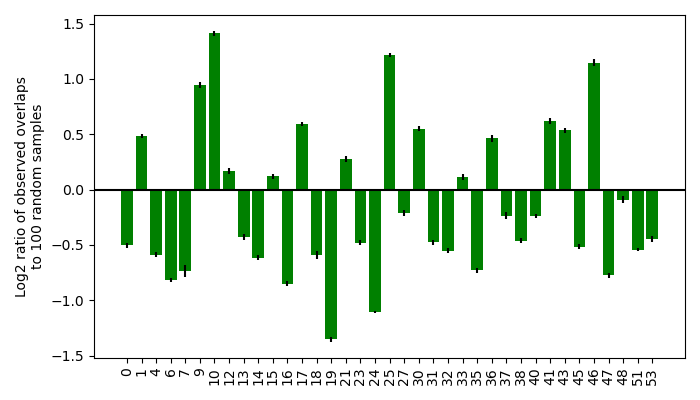

In [14]:
elt1_overlap_arr = numpy.array(elt1_overlap_tfc)[:,0]
elt1_total_arr = numpy.array(elt1_overlap_tfc)[:,1]
non_overlap = elt1_total_arr - elt1_overlap_arr

samples = numpy.random.choice(numpy.arange(elt1_overlap_arr.shape[0]), 
                              size=(100, numpy.sum(elt1_overlap_arr)),
                              replace=True,
                              p=elt1_total_arr/numpy.sum(elt1_total_arr))
samples = numpy.hstack([numpy.sum(samples == elt, axis=1)[:,None] 
                        for elt in range(elt1_overlap_arr.shape[0])])

ratios = numpy.log2((elt1_overlap_arr/samples))
elt1_mean_ratio = numpy.mean(ratios, axis=0)

ratios_sem = stats.sem(ratios, axis=0)
elt1_conf_int = numpy.array([stats.t.interval(0.95, ratios.shape[0]-1, 
                                              loc=elt1_mean_ratio[idx], scale=ratios_sem[idx])
                             for idx in range(ratios.shape[1])]).T
elt1_conf_int[0] = elt1_mean_ratio - elt1_conf_int[0]
elt1_conf_int[1] = elt1_conf_int[1] - elt1_mean_ratio


xlocs = numpy.arange(non_overlap.shape[0])
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(7,4))
axes.bar(xlocs, elt1_mean_ratio, yerr=elt1_conf_int, color='g')
axes.axhline(0,color='k')
axes.set_xticks(xlocs)
axes.set_xticklabels(topics_for_clustering, rotation=90)
axes.set_ylabel('Log2 ratio of observed overlaps\nto 100 random samples')
fig.tight_layout()

In [15]:
elt2_none_tfc = []
elt2_overlap_tfc = []
elt2_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
            'WS245/annotatedPeak.20190420.elt-2.merged.bed')
hotsite_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
               'WS245/PeakClusters.20190420.mean_loc_tf_count.ge40.bed')
for idx in topics_for_clustering:
    topic_total = int(wc('-l', summits[idx]).split()[0])
    
    out_file = os.path.splitext(summits[idx])[0] + '.elt-2_none.bed'
    elt2_none_cmd = (bedtools['intersect', '-v', '-a', elt2_bed, '-b', hotsite_bed] 
                     | bedtools['intersect', '-v', '-a', summits[idx], '-b', 'stdin'] > out_file)
    elt2_none_cmd()
    elt2_none_tfc.append((int(wc('-l', out_file).split()[0]), topic_total))

    out_file = os.path.splitext(summits[idx])[0] + '.elt-2_overlap.bed'
    elt2_overlap_cmd = (bedtools['intersect', '-v', '-a', elt2_bed, '-b', hotsite_bed] 
                        | bedtools['intersect', '-wa', '-a', summits[idx], '-b', 'stdin'] > out_file)
    elt2_overlap_cmd()
    elt2_overlap_tfc.append((int(wc('-l', out_file).split()[0]), topic_total))

    print('{!s}:\tnone:{!s}\toverlaps:{!s}\t({!s}% overlapping)'.format(summits[idx], 
                                                                        elt2_none_tfc[-1][0], 
                                                                        elt2_overlap_tfc[-1][0],
                                                                        round(numpy.divide(*elt2_overlap_tfc[-1])*100,2)))

../topic_analysis/rank_peaks/topic_analysis/0/0_summits_expanded2.bed:	none:7752	overlaps:533	(6.44% overlapping)
../topic_analysis/rank_peaks/topic_analysis/1/1_summits_expanded2.bed:	none:12552	overlaps:2468	(16.46% overlapping)
../topic_analysis/rank_peaks/topic_analysis/4/4_summits_expanded2.bed:	none:6683	overlaps:788	(10.55% overlapping)
../topic_analysis/rank_peaks/topic_analysis/6/6_summits_expanded2.bed:	none:9708	overlaps:802	(7.64% overlapping)
../topic_analysis/rank_peaks/topic_analysis/7/7_summits_expanded2.bed:	none:1376	overlaps:67	(4.64% overlapping)
../topic_analysis/rank_peaks/topic_analysis/9/9_summits_expanded2.bed:	none:4417	overlaps:520	(10.54% overlapping)
../topic_analysis/rank_peaks/topic_analysis/10/10_summits_expanded2.bed:	none:7138	overlaps:805	(10.14% overlapping)
../topic_analysis/rank_peaks/topic_analysis/12/12_summits_expanded2.bed:	none:6008	overlaps:677	(10.13% overlapping)
../topic_analysis/rank_peaks/topic_analysis/13/13_summits_expanded2.bed:	none:

<IPython.core.display.Javascript object>


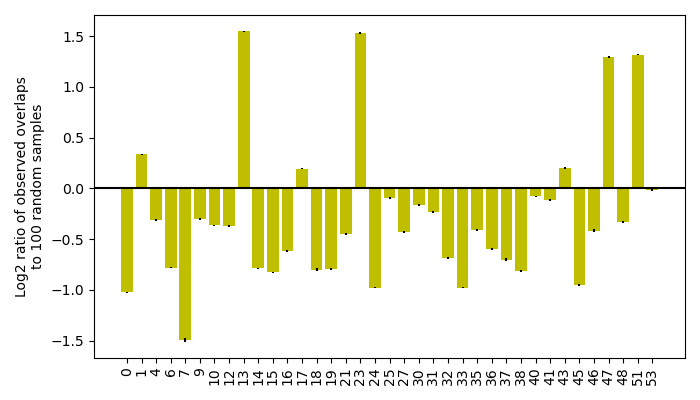

In [16]:
elt2_overlap_arr = numpy.array(elt2_overlap_tfc)[:,0]
elt2_total_arr = numpy.array(elt2_overlap_tfc)[:,1]
non_overlap = elt2_total_arr - elt2_overlap_arr

samples = numpy.random.choice(numpy.arange(elt2_overlap_arr.shape[0]), 
                              size=(100, numpy.sum(elt2_overlap_arr)),
                              replace=True,
                              p=elt2_total_arr/numpy.sum(elt2_total_arr))
samples = numpy.hstack([numpy.sum(samples == elt, axis=1)[:,None] 
                        for elt in range(elt2_overlap_arr.shape[0])])

ratios = numpy.log2((elt2_overlap_arr/samples))
elt2_mean_ratio = numpy.mean(ratios, axis=0)

ratios_sem = stats.sem(ratios, axis=0)
elt2_conf_int = numpy.array([stats.t.interval(0.95, ratios.shape[0]-1, 
                                              loc=elt2_mean_ratio[idx], scale=ratios_sem[idx])
                             for idx in range(ratios.shape[1])]).T
elt2_conf_int[0] = elt2_mean_ratio - elt2_conf_int[0]
elt2_conf_int[1] = elt2_conf_int[1] - elt2_mean_ratio


xlocs = numpy.arange(non_overlap.shape[0])
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(7,4))
axes.bar(xlocs, elt2_mean_ratio, yerr=elt2_conf_int, color='y')
axes.axhline(0,color='k')
axes.set_xticks(xlocs)
axes.set_xticklabels(topics_for_clustering, rotation=90)
axes.set_ylabel('Log2 ratio of observed overlaps\nto 100 random samples')
fig.tight_layout()

<IPython.core.display.Javascript object>


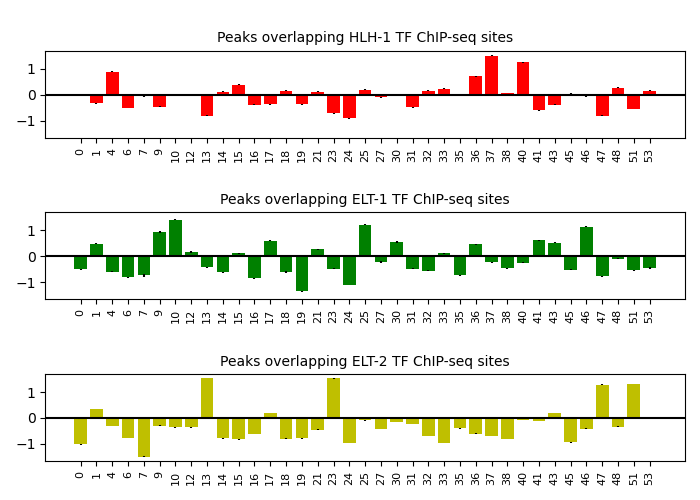

In [21]:
xlocs = numpy.arange(non_overlap.shape[0])
ticklabels = topics_for_clustering
titlesize=10
labelsize=8
fig, axes = pyplot.subplots(nrows=3, ncols=1, figsize=(7,5), sharey=True)
axes[0].bar(xlocs, hlh1_mean_ratio, yerr=hlh1_conf_int, color='r')
axes[0].axhline(0,color='k')
axes[0].set_xticks(xlocs)
axes[0].set_xticklabels(ticklabels, fontsize=labelsize, rotation=90)
#axes[0].set_ylabel('Log2 ratio of observed overlaps\nto 100 random samples')
axes[0].set_title('\nPeaks overlapping HLH-1 TF ChIP-seq sites', fontsize=titlesize)

axes[1].bar(xlocs, elt1_mean_ratio, yerr=elt1_conf_int, color='g')
axes[1].axhline(0,color='k')
axes[1].set_xticks(xlocs)
axes[1].set_xticklabels(ticklabels, fontsize=labelsize, rotation=90)
#axes[1].set_ylabel('Log2 ratio of observed overlaps to 100 random samples')
axes[1].set_title('\nPeaks overlapping ELT-1 TF ChIP-seq sites', fontsize=titlesize)

axes[2].bar(xlocs, elt2_mean_ratio, yerr=elt2_conf_int, color='y')
axes[2].axhline(0,color='k')
axes[2].set_xticks(xlocs)
axes[2].set_xticklabels(ticklabels, fontsize=labelsize, rotation=90)
#axes[2].set_ylabel('Log2 ratio of observed overlaps\nto 100 random samples')
axes[2].set_title('\nPeaks overlapping ELT-2 TF ChIP-seq sites', fontsize=titlesize)
#axes[2].set_xlabel('Topic number')
fig.tight_layout()

## Do a more systematic analysis of TFs

In [18]:
all_chip_peaks_path = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/WS245/'
                       'annotatedPeak.20190420.bed')
with open(all_chip_peaks_path) as lines_in:
    try:
        all_tf_ids = sorted(set([elt.strip().split()[3] for elt in lines_in]))
    except:
        print(lines_in.__next__())
        raise
all_tfs = sorted(set([elt.split('_')[0] for elt in all_tf_ids]))
print(len(all_tf_ids))
print(len(all_tfs))
print(all_tfs[:5])

427
283
['B0035.1', 'B0261.1', 'B0310.2', 'C04F5.9', 'C08G9.2']


In [19]:
total_data = []
hotsite_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
               'WS245/PeakClusters.20190420.mean_loc_tf_count.ge40.bed')
topic_peak_counts = {idx:int(wc('-l', summits[idx]).split()[0]) for idx in topics_for_clustering}
numpy.random.seed(5)
for tf_idx, tf_elt in enumerate(all_tfs):
    print(tf_idx, tf_elt)
    tf_bed_data = (local['cut']['-f', '1-6', all_chip_peaks_path]
                   | local['grep'][tf_elt + '_']
                   | local['sort']['-k1,1', '-k2,2n']
                   | bedtools['merge', '-i', 'stdin']
                   | bedtools['intersect', '-v', '-a', 'stdin', '-b', hotsite_bed])()
#    none_tfc = []
    overlap_tfc = []
    #get counts of overlapping and non-overlapping elements between the TF and each topic
    for idx in topics_for_clustering:
        topic_total = topic_peak_counts[idx]

        overlap_count = int((bedtools['intersect', '-wa', '-a', summits[idx], '-b', 'stdin'] << tf_bed_data
                             | wc['-l'])().split()[0])
        overlap_tfc.append((overlap_count, topic_total))
    #now compute the enrichment/depletion of overlaps for each topic
    overlap_arr = numpy.array(overlap_tfc)[:,0]
    total_arr = numpy.array(overlap_tfc)[:,1]
    non_overlap = total_arr - overlap_arr

    samples = numpy.random.choice(numpy.arange(overlap_arr.shape[0]), 
                                  size=(500, numpy.sum(overlap_arr)),
                                  replace=True,
                                  p=total_arr/numpy.sum(total_arr))
    samples = numpy.hstack([numpy.sum(samples == elt, axis=1)[:,None] 
                            for elt in range(overlap_arr.shape[0])])
    
    ratios = numpy.log2((overlap_arr/samples))
    mean_ratio = numpy.mean(ratios, axis=0)
    mean_ratio[numpy.isinf(mean_ratio)] = numpy.nan
#    mean_ratio = numpy.nan_to_num(mean_ratio,
#                                  nan=0.0, posinf=numpy.max(mean_ratio), neginf=numpy.min(mean_ratio))
    total_data.append(mean_ratio)
total_data = numpy.array(total_data)

#set any inf values to the maximum or minimum ratio seen among other data points
#posinf = total_data == 1e6
#total_data[posinf] = numpy.max(total_data[~posinf])
#neginf = total_data == -1e6
#total_data[neginf] = numpy.min(total_data[~neginf])

print(total_data.shape)

0 B0035.1


/net/gs/vol1/home/tdurham/src/anaconda/envs/python3_remake2/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


1 B0261.1
2 B0310.2
3 C04F5.9
4 C08G9.2
5 C16A3.4
6 C34B4.2
7 C34F6.9
8 C38D4.7
9 F10B5.3
10 F10E7.11
11 F13C5.2
12 F13H6.1
13 F16B12.6
14 F22D6.2
15 F23B12.7
16 F37D6.2
17 F49E8.2
18 F52B5.7
19 F55B11.4


/net/gs/vol1/home/tdurham/src/anaconda/envs/python3_remake2/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/net/gs/vol1/home/tdurham/src/anaconda/envs/python3_remake2/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log2


20 F57A8.1
21 F57C9.4
22 K02D7.2
23 K09A11.1
24 K12H6.12
25 M03D4.4
26 R02D3.7
27 T07F8.4
28 T20F7.1
29 T23F11.4
30 T26A5.8
31 W03F9.2
32 Y116A8C.19
33 Y22D7AL.16
34 Y55F3AM.14
35 Y5F2A.4
36 ZK185.1
37 ZK546.5
38 aha-1
39 ahr-1
40 akir-1
41 alr-1
42 aly-1
43 aly-2
44 ama-1
45 atf-7
46 athp-1
47 attf-4
48 attf-5
49 bed-3
50 blmp-1
51 ccch-3
52 cebp-1
53 ceh-13
54 ceh-14
55 ceh-16
56 ceh-18
57 ceh-19
58 ceh-2
59 ceh-22
60 ceh-24
61 ceh-27
62 ceh-28
63 ceh-30
64 ceh-31
65 ceh-32
66 ceh-34
67 ceh-36
68 ceh-39
69 ceh-43
70 ceh-48
71 ceh-6
72 ceh-62
73 ceh-63
74 ceh-79
75 ceh-8
76 ceh-82
77 ceh-83
78 ceh-9
79 ceh-90
80 ces-1
81 cey-2
82 chd-7
83 che-1
84 cnd-1
85 cog-1
86 crh-2
87 daf-12
88 daf-16
89 dao-5
90 die-1
91 dmd-4
92 dpff-1
93 dpl-1
94 drap-1
95 dsc-1
96 duxl-1
97 dve-1
98 efl-1
99 efl-3
100 egl-13
101 egl-27
102 egl-5
103 elt-1
104 elt-2
105 elt-3
106 elt-4
107 eor-1
108 ets-4
109 ets-7
110 eyg-1
111 fax-1
112 fkh-10
113 fkh-2
114 fkh-3
115 fkh-4
116 fkh-6
117 fkh-8
118 flh-1
119 

<IPython.core.display.Javascript object>


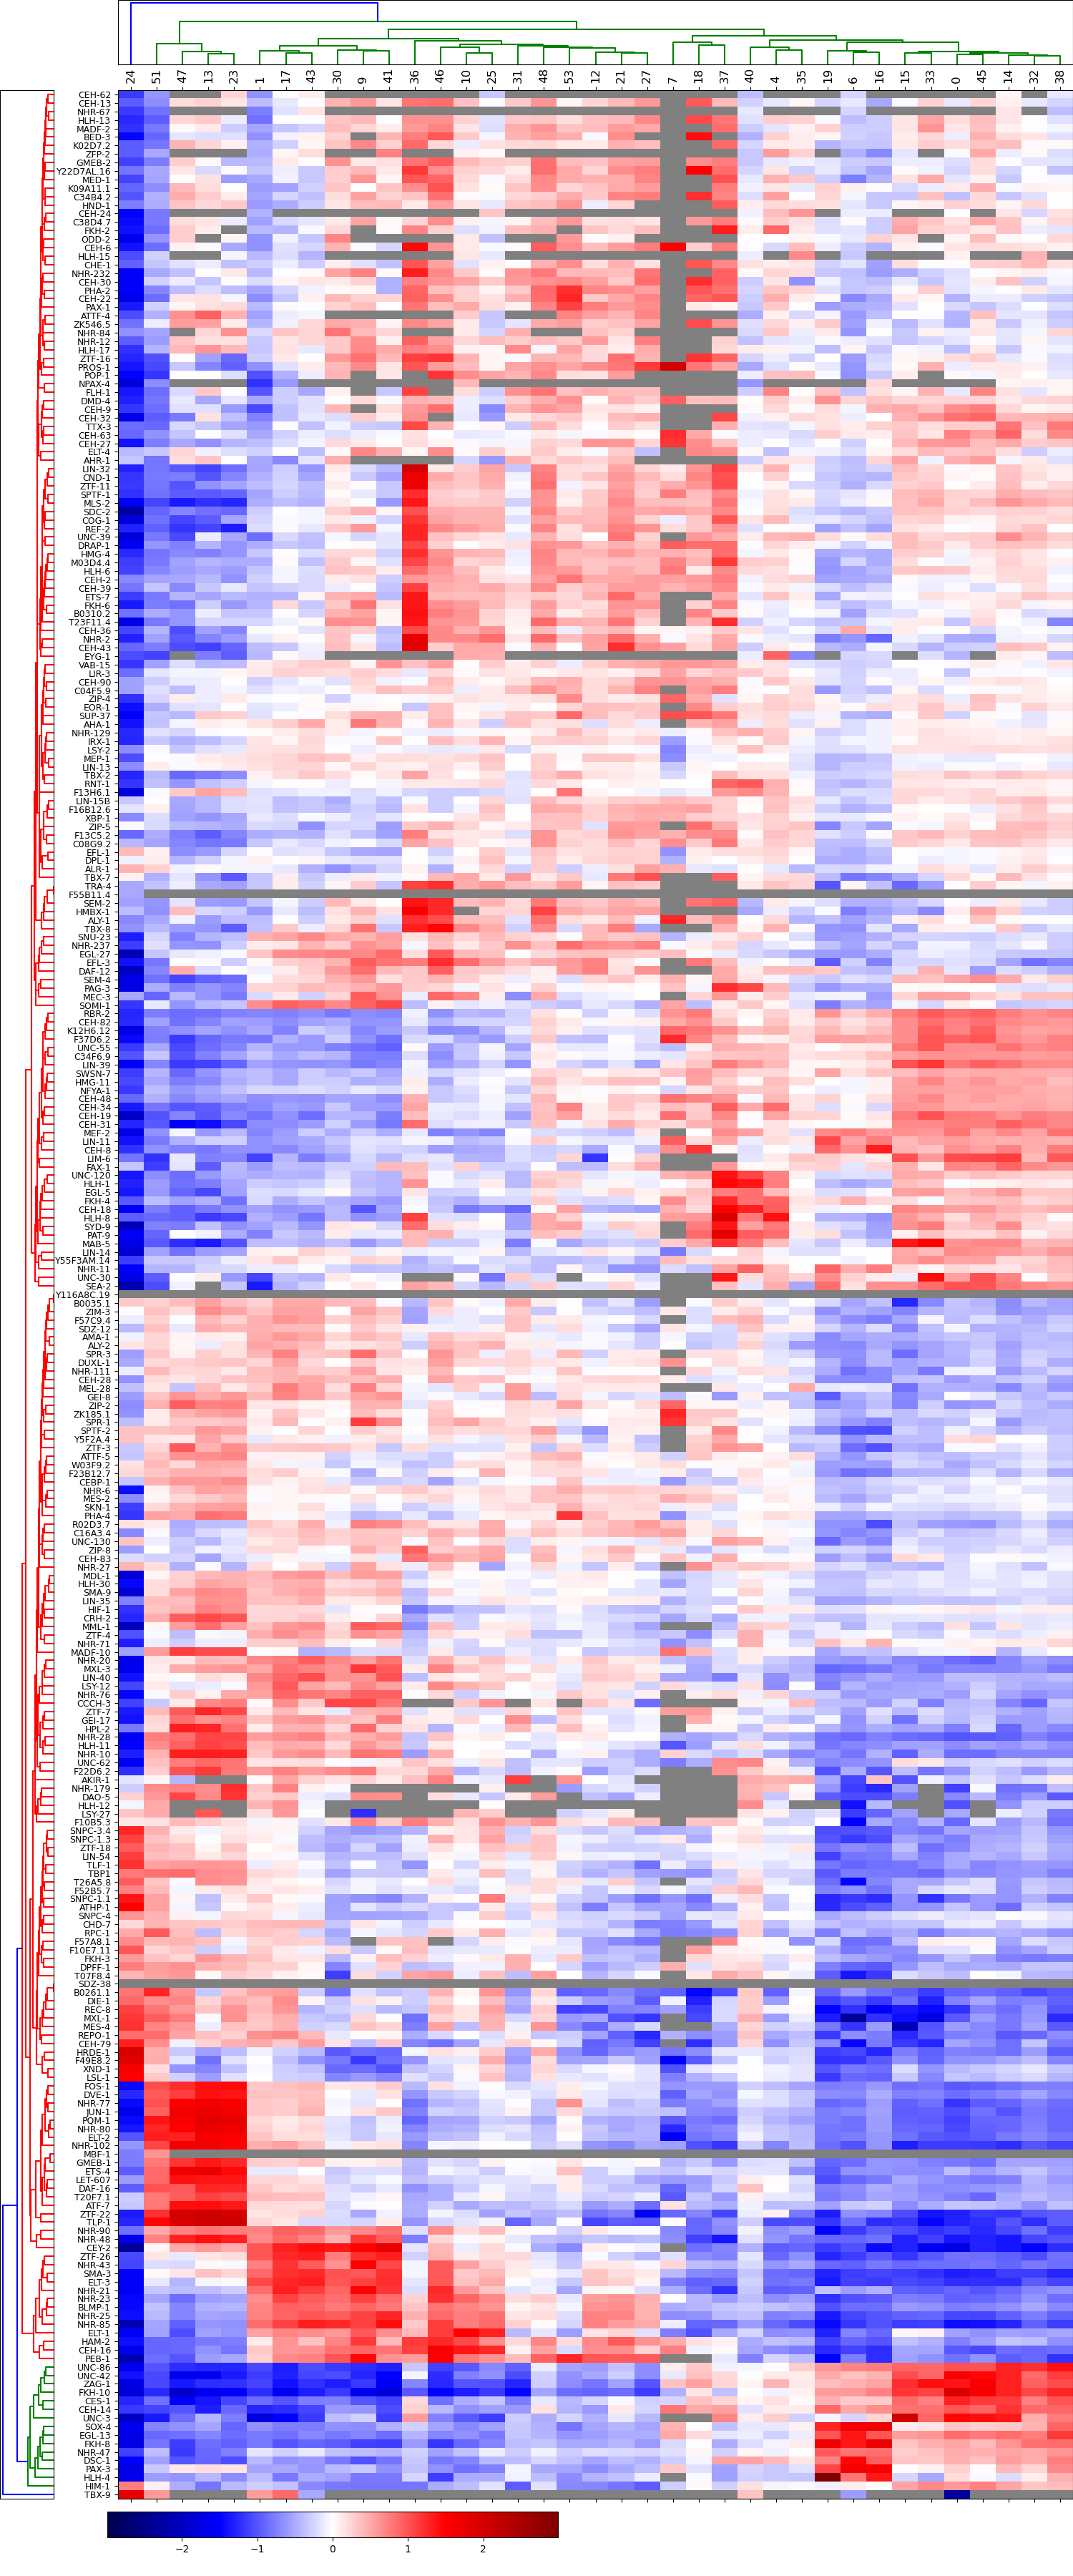

In [22]:
from sklearn.metrics import pairwise

fig = pyplot.figure(figsize=(15,36))

# axm, placement of heatmap for the data matrix
[axm_x, axm_y, axm_w, axm_h] = [0.11, 0.03, 0.89, 0.935]

# ax1, placement of dendrogram 1, to the left of the heatmap
[ax1_x, ax1_y, ax1_w, ax1_h] = [0, 0.03, 0.05, 0.935]

# ax2, placement of dendrogram 2, on the top of the heatmap
[ax2_x, ax2_y, ax2_w, ax2_h] = [0.11, 0.975, 0.89, 0.025]

# axcb - placement of the color legend
[axcb_x, axcb_y, axcb_w, axcb_h] = [0.1, 0.015, 0.42, 0.01]

#plot dendrogram of rows
ax1 = fig.add_axes([ax1_x, ax1_y, ax1_w, ax1_h])
#Note: these were treated as samples by features, not distance matrices...
#dist1 = distance.squareform(distance.pdist(doctopic_norm, metric='cosine'))
e_dists1 = pairwise.nan_euclidean_distances(total_data, squared=False, missing_values=numpy.nan, copy=True)
dist1 = distance.squareform(numpy.nan_to_num(numpy.maximum(e_dists1, e_dists1.T)))
#dist1 = distance.pdist(total_data, metric='cosine')
#nonfinite_idx = numpy.where(~numpy.isfinite(dist1))
#dist1[nonfinite_idx] = 0
#print(nonfinite_idx)
#dist1[nonfinite_idx] = numpy.random.normal(0,0.001, size=dist1.shape)
#print(type(dist1))
Y1 = hierarchy.linkage(dist1, method='average')
Z1 = hierarchy.dendrogram(Y1, orientation='left', no_labels=True, ax=ax1, count_sort=True)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_yticks([])
ax1.set_yticklabels([])

#plot dendrogram of cols
ax2 = fig.add_axes([ax2_x, ax2_y, ax2_w, ax2_h])
#Note: these were treated as samples by features, not distance matrices...
#dist2 = distance.squareform(distance.pdist(doctopic_norm.T, metric='cosine'))
#dist2 = distance.pdist(total_data.T, metric='cosine')
e_dists2 = pairwise.nan_euclidean_distances(total_data.T, squared=False, missing_values=numpy.nan, copy=True)
dist2 = distance.squareform(numpy.nan_to_num(numpy.maximum(e_dists2, e_dists2.T)))
#nonfinite_idx = numpy.where(~numpy.isfinite(dist2))
#dist2[nonfinite_idx] = 0
Y2_nontf = hierarchy.linkage(dist2, method='average')
Z2_nontf = hierarchy.dendrogram(Y2_nontf, orientation='top', no_labels=True, ax=ax2, count_sort=True)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.set_yticks([])
ax2.set_yticklabels([])

#plot heatmap
ax3 = fig.add_axes([axm_x, axm_y, axm_w, axm_h])
h_index1 = Z1['leaves']
h_index2 = Z2_nontf['leaves']
resort_x = total_data[h_index1,:]
resort_x = resort_x[:,h_index2]

current_cmap = matplotlib.cm.get_cmap('seismic')
current_cmap.set_bad(color='grey')
maxabs = numpy.max(numpy.absolute(total_data[~numpy.isnan(total_data)]))
im = ax3.matshow(resort_x, cmap=current_cmap, vmin=0-maxabs, vmax=maxabs, aspect='auto', origin='lower')

#for elt in range(0, 10000, 500):
#    ax3.axhline(elt, color='r')

xlocs = numpy.arange(total_data.shape[1])
ax3.set_xticks(xlocs)
ax3.set_xticklabels(numpy.array(topics_for_clustering)[h_index2], fontsize=12, rotation=90)

ylocs = numpy.arange(total_data.shape[0])
ax3.set_yticks(ylocs)
ax3.set_yticklabels(numpy.array([elt.upper() for elt in all_tfs])[h_index1], fontsize=9)

#left, bottom, width, height
cbaxes = fig.add_axes([axcb_x, axcb_y, axcb_w, axcb_h])
cb = fig.colorbar(im, orientation='horizontal', cax=cbaxes)

#ax3.set_yticks(numpy.arange(doctopic_norm.shape[0]))
#ax3.set_yticklabels(numpy.array(x_labels)[h_index1])

fig.show()
fig.savefig('./peak_investigation.all_tf_topic_dists.pdf', bbox_inches='tight')

## Check the percentage of the genome covered by sci-ATAC-seq peaks and ChIP TF sites

In [27]:
ce11_sizes_path = 'ATAC_sequencing/2018_worm_atac/ref_data/WS235/c_elegans.WS235.chrom.sizes'
ce11_genome_size = numpy.loadtxt(ce11_sizes_path, delimiter='\t', dtype=object)[:,1].astype(int).sum()
print('ce11 genome size is {!s}'.format(ce11_genome_size))

peaks_merge = ('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
               'topic_analysis/rank_peaks/topic_analysis/test_merge_and_expand/all_summits_expanded2.merged.expanded2.bed')
peaks_merge_data = numpy.loadtxt(peaks_merge, delimiter='\t', dtype=object)[:,[1,2]].astype(int)
peaks_len_total = numpy.sum(peaks_merge_data[:,1] - peaks_merge_data[:,0])
peaks_pct = round((peaks_len_total/ce11_genome_size)*100, 2)
print('{!s} sci-ATAC-seq peaks cover {!s} bp, or {!s}% of the genome.'.format(peaks_merge_data.shape[0],
                                                                              peaks_len_total, peaks_pct))

tf_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
          'WS245/annotatedPeak.20190420.merged.bed')
tf_merge_data = numpy.loadtxt(tf_bed, delimiter='\t', dtype=object)[:,[1,2]].astype(int)
tf_len_total = numpy.sum(tf_merge_data[:,1] - tf_merge_data[:,0])
tf_pct = round((tf_len_total/ce11_genome_size) * 100, 2)
print('{!s} ChIP-seq peaks cover {!s} bp, or {!s}% of the genome.'.format(tf_merge_data.shape[0],
                                                                          tf_len_total, tf_pct))

janes_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/TSS/'
             'janes2018/janes2018_fig2_data1_v2.all_ce11_coords.merged.bed')
janes_merge_data = numpy.loadtxt(janes_bed, delimiter='\t', dtype=object)[:,[1,2]].astype(int)
janes_len_total = numpy.sum(janes_merge_data[:,1] - janes_merge_data[:,0])
janes_pct = round((janes_len_total/ce11_genome_size) * 100, 2)
print('{!s} bulk ATAC-seq peaks cover {!s} bp, or {!s}% of the genome.'.format(janes_merge_data.shape[0],
                                                                               janes_len_total, janes_pct))

print()
overlapping_bases_tf = numpy.array([list(elt.split()[1:3]) for elt in 
                                    bedtools('intersect', '-a', peaks_merge, '-b', tf_bed).strip().split('\n')], dtype=int)
total_overlaps_tf = numpy.sum(overlapping_bases_tf[:,1] - overlapping_bases_tf[:,0])
tf_overlaps_pct = round((total_overlaps_tf/ce11_genome_size)*100,2)
print('Total overlapping bp with ChIP-seq peaks: {!s} ({!s}% of genome)'.format(total_overlaps_tf, tf_overlaps_pct))

overlapping_bases_janes = numpy.array([elt.split()[1:3] for elt in
                                       bedtools('intersect', '-a', peaks_merge, '-b', janes_bed).strip().split('\n')], dtype=int)
total_overlaps_janes = numpy.sum(overlapping_bases_janes[:,1] - overlapping_bases_janes[:,0])
janes_overlaps_pct = round((total_overlaps_janes/ce11_genome_size)*100,2)
print('Total overlapping bp with bulk ATAC-seq peaks: {!s} ({!s}% of genome)'.format(total_overlaps_janes, 
                                                                                     janes_overlaps_pct))

ce11 genome size is 100286401
38017 sci-ATAC-seq peaks cover 20234260 bp, or 20.18% of the genome.
41542 ChIP-seq peaks cover 23225218 bp, or 23.16% of the genome.
42102 bulk ATAC-seq peaks cover 6376655 bp, or 6.36% of the genome.

Total overlapping bp with ChIP-seq peaks: 13385215 (13.35% of genome)
Total overlapping bp with bulk ATAC-seq peaks: 4320147 (4.31% of genome)


In [29]:
print(bedtools('fisher', '-a', peaks_merge, '-b', tf_bed, '-g', ce11_sizes_path))

# Number of query intervals: 38017
# Number of db intervals: 41542
# Number of overlaps: 33762
# Number of possible intervals (estimated): 91726
# phyper(33762 - 1, 38017, 91726 - 38017, 41542, lower.tail=F)
# Contingency Table Of Counts
#_________________________________________
#           |  in -b       | not in -b    |
#     in -a | 33762        | 4255         |
# not in -a | 7780         | 45929        |
#_________________________________________
# p-values for fisher's exact test
left	right	two-tail	ratio
1	0	0	46.842



In [30]:
print(bedtools('fisher', '-a', peaks_merge, '-b', janes_bed, '-g', ce11_sizes_path))

# Number of query intervals: 38017
# Number of db intervals: 42102
# Number of overlaps: 29681
# Number of possible intervals (estimated): 146254
# phyper(29681 - 1, 38017, 146254 - 38017, 42102, lower.tail=F)
# Contingency Table Of Counts
#_________________________________________
#           |  in -b       | not in -b    |
#     in -a | 29681        | 8336         |
# not in -a | 12421        | 95816        |
#_________________________________________
# p-values for fisher's exact test
left	right	two-tail	ratio
1	0	0	27.466



## Analyze sci-ATAC-seq and ChIP TF site overlaps

In [26]:
peaks_merge = ('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
               'topic_analysis/rank_peaks/topic_analysis/test_merge_and_expand/all_summits_expanded2.merged.expanded2.bed')
#peaks_merge = ('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
#               'all_lda1_peaks.scored_filtered_merged_colored.tissue_merged.overlaps_merged_for_lda.bed')
tf_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
          'WS245/annotatedPeak.20190420.merged.bed')
tf_eq1_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
              'WS245/PeakClusters.20190420.mean_loc_tf_count.eq1.bed')
sci_total = wc('-l', peaks_merge).strip().split()[0]
cmd = (local['cut']['-f1-3', tf_bed] 
       | bedtools['intersect', '-v', '-a', 'stdin', '-b', tf_eq1_bed]
       | bedtools['intersect', '-u', '-a', peaks_merge, '-b', 'stdin'] 
       | wc['-l'])
sci_tfs_neq1 = (int(cmd().strip()), int(sci_total))
print('ATAC peaks overlapping TF clusters of size > 1: {!s}/{!s}'.format(*sci_tfs_neq1))

tf_neq1_total = (local['cut']['-f1-3', tf_bed] 
            | bedtools['intersect', '-v', '-a', 'stdin', '-b', tf_eq1_bed]
            | wc['-l'])().strip()
cmd = (local['cut']['-f1-3', tf_bed] 
       | bedtools['intersect', '-v', '-a', 'stdin', '-b', tf_eq1_bed]
       | bedtools['intersect', '-u', '-b', peaks_merge, '-a', 'stdin'] 
       | wc['-l'])
tfs_neq1_sci = (int(cmd().strip()), int(tf_neq1_total))
print('TF clusters of size > 1 overlapping ATAC peaks: {!s}/{!s}'.format(*tfs_neq1_sci))

ATAC peaks overlapping TF clusters of size > 1: 12803/38017
TF clusters of size > 1 overlapping ATAC peaks: 10536/14636


In [27]:
tf_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
          'WS245/annotatedPeak.20190420.merged.bed')
#peaks_merge = ('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
#               'all_lda1_peaks.scored_filtered_merged_colored.tissue_merged.overlaps_merged_for_lda.bed')
peaks_merge = ('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
               'topic_analysis/rank_peaks/topic_analysis/test_merge_and_expand/all_summits_expanded2.merged.expanded2.bed')
sci_total = wc('-l', peaks_merge).strip().split()[0]
cmd = bedtools['intersect', '-u', '-a', peaks_merge, '-b', tf_bed] | wc['-l']
sci_tfs = (int(cmd().strip()), int(sci_total))
print('ATAC peaks overlapping TF peaks: {!s}/{!s}'.format(*sci_tfs))

tf_total = wc('-l', tf_bed).strip().split()[0]
cmd = bedtools['intersect', '-u', '-b', peaks_merge, '-a', tf_bed] | wc['-l']
tfs_sci = (int(cmd().strip()), int(tf_total))
print('TF peaks overlapping ATAC peaks: {!s}/{!s}'.format(*tfs_sci))

ATAC peaks overlapping TF peaks: 30886/38017
TF peaks overlapping ATAC peaks: 23863/41542


## Janes et al. 2018 overlap

In [45]:
pandas.set_option('display.max_rows', 500)
pandas.set_option('display.max_columns', 500)

In [47]:
janes2018_fig1 = pandas.read_csv('ATAC_sequencing/2018_worm_atac/ref_data/TSS/'
                                 'janes2018/janes2018_fig1_data1_v2.txt', sep='\t')
print(janes2018_fig1.shape)
janes2018_fig1.head()

(42245, 15)


,chrom,start,end,atac_wt_emb_height,atac_wt_l1_height,atac_wt_l2_height,atac_wt_l3_height,atac_wt_l4_height,atac_wt_ya_height,atac_glp1_d1_height,atac_glp1_d2_height,atac_glp1_d6_height,atac_glp1_d9_height,atac_glp1_d13_height,atac_source
0,chrI,1900,2051,1.49,1.44,1.23,1.48,1.18,3.03,0.98,0.91,1.16,1.19,1.63,atac_wt_se
1,chrI,3826,3977,67.20,58.45,74.42,133.74,179.79,211.37,88.03,69.67,68.51,64.59,55.76,atac_wt_pe
2,chrI,4276,4427,1.58,2.66,2.19,3.50,5.87,7.77,1.80,1.33,1.55,2.07,1.81,atac_wt_se
3,chrI,11272,11423,2.61,4.44,9.83,10.70,11.68,13.93,20.86,16.74,17.59,15.86,17.17,atac_wt_pe
4,chrI,13070,13221,5.56,3.61,3.98,3.40,2.69,2.95,2.05,2.08,1.99,2.59,3.20,atac_wt_pe


In [48]:
janes2018_fig2 = pandas.read_csv('ATAC_sequencing/2018_worm_atac/ref_data/TSS/'
                                 'janes2018/janes2018_fig2_data1_v2.txt', sep='\t')
print(janes2018_fig2.shape)
janes2018_fig2.head()

(42245, 67)


,chrom_ce10,start_ce10,end_ce10,chrom_ce11,start_ce11,end_ce11,annot,annot_fwd,annot_rev,promoter_gene_id_fwd,promoter_locus_id_fwd,promoter_gene_biotype_fwd,promoter_gene_id_rev,promoter_locus_id_rev,promoter_gene_biotype_rev,associated_gene_id,associated_locus_id,tss_fwd_ce10,tss_rev_ce10,tss_fwd_ce11,tss_rev_ce11,scap_fwd_passed,scap_rev_passed,lcap_wt_emb_fwd_passed_jump,lcap_wt_l1_fwd_passed_jump,lcap_wt_l2_fwd_passed_jump,lcap_wt_l3_fwd_passed_jump,lcap_wt_l4_fwd_passed_jump,lcap_wt_ya_fwd_passed_jump,lcap_glp1_d1_fwd_passed_jump,lcap_glp1_d2_fwd_passed_jump,lcap_glp1_d6_fwd_passed_jump,lcap_glp1_d9_fwd_passed_jump,lcap_glp1_d13_fwd_passed_jump,lcap_wt_emb_fwd_passed_incr,lcap_wt_l1_fwd_passed_incr,lcap_wt_l2_fwd_passed_incr,lcap_wt_l3_fwd_passed_incr,lcap_wt_l4_fwd_passed_incr,lcap_wt_ya_fwd_passed_incr,lcap_glp1_d1_fwd_passed_incr,lcap_glp1_d2_fwd_passed_incr,lcap_glp1_d6_fwd_passed_incr,lcap_glp1_d9_fwd_passed_incr,lcap_glp1_d13_fwd_passed_incr,lcap_wt_emb_rev_passed_jump,lcap_wt_l1_rev_passed_jump,lcap_wt_l2_rev_passed_jump,lcap_wt_l3_rev_passed_jump,lcap_wt_l4_rev_passed_jump,lcap_wt_ya_rev_passed_jump,lcap_glp1_d1_rev_passed_jump,lcap_glp1_d2_rev_passed_jump,lcap_glp1_d6_rev_passed_jump,lcap_glp1_d9_rev_passed_jump,lcap_glp1_d13_rev_passed_jump,lcap_wt_emb_rev_passed_incr,lcap_wt_l1_rev_passed_incr,lcap_wt_l2_rev_passed_incr,lcap_wt_l3_rev_passed_incr,lcap_wt_l4_rev_passed_incr,lcap_wt_ya_rev_passed_incr,lcap_glp1_d1_rev_passed_incr,lcap_glp1_d2_rev_passed_incr,lcap_glp1_d6_rev_passed_incr,lcap_glp1_d9_rev_passed_incr,lcap_glp1_d13_rev_passed_incr
0,chrI,1900,2051,chrI,1900,2051,putative_enhancer,transcription_initiation,transcription_initiation,.,.,.,.,.,.,.,.,2008,1957,2008,1957,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,chrI,3826,3977,chrI,3826,3977,non-coding_RNA,unassigned_promoter,non-coding_RNA,.,.,.,WBGene00023193,Y74C9A.6,snoRNA,.,.,3905,3908,3905,3908,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True,True,False,True,True,True,True
2,chrI,4276,4427,chrI,4276,4427,putative_enhancer,no_transcription,transcription_initiation,.,.,.,.,.,.,WBGene00022277,homt-1,4411,4363,4411,4363,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False
3,chrI,11272,11423,chrI,11272,11423,coding_promoter,coding_promoter,coding_promoter,WBGene00022276,nlp-40,protein_coding,WBGene00022277,homt-1,protein_coding,.,.,11293,11415,11293,11415,True,True,False,True,True,True,True,True,True,True,True,True,True,False,False,False,True,False,False,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True
4,chrI,13070,13221,chrI,13070,13221,putative_enhancer,no_transcription,transcription_initiation,.,.,.,.,.,.,WBGene00022276,nlp-40,13205,13039,13205,13039,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [65]:
len(sig_tps['index'])

0

In [75]:
from scipy import stats
height_cols = janes2018_fig1.columns[janes2018_fig1.columns.str.contains('height')]
sig_tps = {'index':[],
           'timepoint':[]}
for row_idx in janes2018_fig1.index.values:
    zscores = stats.zscore(janes2018_fig1.loc[row_idx,height_cols].to_numpy().astype(float))
    for col_idx in numpy.where(zscores >= 1.5)[0]:
        sig_tps['index'].append(row_idx)
        sig_tps['timepoint'].append(height_cols[col_idx])
janes2018_fig1_w_tp = janes2018_fig1.join(pandas.DataFrame(sig_tps).set_index('index'))
print(janes2018_fig1_w_tp.shape)
janes2018_fig1_w_tp.head(10)

/net/gs/vol1/home/tdurham/src/anaconda/envs/python3_remake2/lib/python3.6/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/net/gs/vol1/home/tdurham/src/anaconda/envs/python3_remake2/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys


(47223, 16)


,chrom,start,end,atac_wt_emb_height,atac_wt_l1_height,atac_wt_l2_height,atac_wt_l3_height,atac_wt_l4_height,atac_wt_ya_height,atac_glp1_d1_height,atac_glp1_d2_height,atac_glp1_d6_height,atac_glp1_d9_height,atac_glp1_d13_height,atac_source,timepoint
0,chrI,1900,2051,1.49,1.44,1.23,1.48,1.18,3.03,0.98,0.91,1.16,1.19,1.63,atac_wt_se,atac_wt_ya_height
1,chrI,3826,3977,67.20,58.45,74.42,133.74,179.79,211.37,88.03,69.67,68.51,64.59,55.76,atac_wt_pe,atac_wt_l4_height
1,chrI,3826,3977,67.20,58.45,74.42,133.74,179.79,211.37,88.03,69.67,68.51,64.59,55.76,atac_wt_pe,atac_wt_ya_height
2,chrI,4276,4427,1.58,2.66,2.19,3.50,5.87,7.77,1.80,1.33,1.55,2.07,1.81,atac_wt_se,atac_wt_ya_height
3,chrI,11272,11423,2.61,4.44,9.83,10.70,11.68,13.93,20.86,16.74,17.59,15.86,17.17,atac_wt_pe,NaN
4,chrI,13070,13221,5.56,3.61,3.98,3.40,2.69,2.95,2.05,2.08,1.99,2.59,3.20,atac_wt_pe,atac_wt_emb_height
5,chrI,15430,15581,1.90,2.26,3.62,6.12,7.22,14.82,10.11,4.92,5.84,6.11,6.39,atac_wt_pe,atac_wt_ya_height
6,chrI,15722,15873,1.69,1.76,0.81,3.65,4.25,24.75,1.93,1.08,1.16,1.44,2.25,atac_wt_pe,atac_wt_ya_height
7,chrI,16958,17109,25.06,17.81,11.96,22.98,19.72,22.07,24.31,20.91,22.12,25.73,22.04,atac_wt_pe,NaN
8,chrI,22266,22417,1.37,1.36,1.22,1.35,1.03,2.26,5.23,3.41,3.63,4.00,2.19,atac_wt_pe,atac_glp1_d1_height


In [77]:
ce11_peak_coords_w_tp = janes2018_fig2.join(janes2018_fig1_w_tp.set_index(['chrom', 'start', 'end']),
                                            on=['chrom_ce10', 'start_ce10', 'end_ce10'])[['chrom_ce11', 'start_ce11', 'end_ce11', 'timepoint']]
print(ce11_peak_coords_w_tp.shape)
ce11_peak_coords_w_tp.head(10)

(47223, 4)


,chrom_ce11,start_ce11,end_ce11,timepoint
0,chrI,1900,2051,atac_wt_ya_height
1,chrI,3826,3977,atac_wt_l4_height
1,chrI,3826,3977,atac_wt_ya_height
2,chrI,4276,4427,atac_wt_ya_height
3,chrI,11272,11423,NaN
4,chrI,13070,13221,atac_wt_emb_height
5,chrI,15430,15581,atac_wt_ya_height
6,chrI,15722,15873,atac_wt_ya_height
7,chrI,16958,17109,NaN
8,chrI,22266,22417,atac_glp1_d1_height


<IPython.core.display.Javascript object>


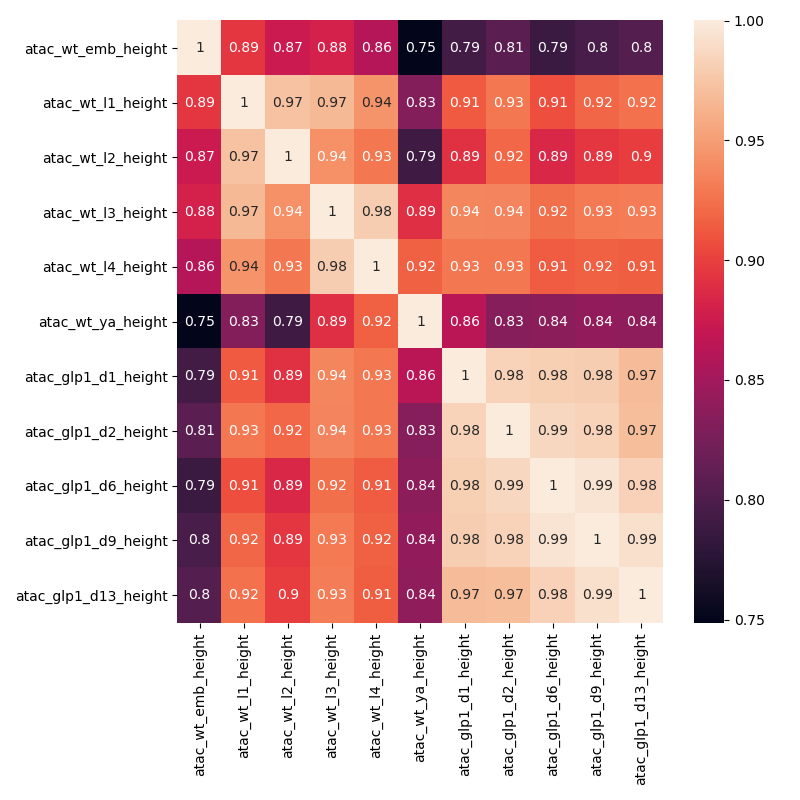

In [90]:
corr_mat = janes2018_fig1[height_cols].corr()

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(8,8))
seaborn.heatmap(corr_mat, annot=True, ax=axes)
fig.tight_layout()

In [91]:
out_dir = 'ATAC_sequencing/2018_worm_atac/ref_data/TSS/janes2018/'
ce11_peak_coords_w_tp = ce11_peak_coords_w_tp[~ce11_peak_coords_w_tp['timepoint'].isnull()]
for tp in ['emb_', 'l1_', 'l2_', 'l3_', 'l4_', 'ya_', 'd1_', 'd2_', 'd6_', 'd9_', 'd13_']:
    tp_peaks = ce11_peak_coords_w_tp[ce11_peak_coords_w_tp['timepoint'].str.contains(tp)]
    out_path = os.path.join(out_dir, 'janes2018_atac_peaks.{!s}.bed'.format(tp[:-1]))
    tp_peaks[['chrom_ce11', 'start_ce11', 'end_ce11']].to_csv(out_path, sep='\t', index=False, header=False)

In [92]:
atac_beds = glob.glob('ATAC_sequencing/2018_worm_atac/ref_data/TSS/'
                      'janes2018/janes2018_atac_peaks.*.bed')
#the glp-1 mutant data sets are all correlated with each other and with all developmental 
#  samples except emb and young adult. This is pretty strange, so I'm going to only compare
#  the developmental samples, since they were all produced with the same worm strain and 
#  with the same technology.
atac_beds = [elt for elt in atac_beds if not elt.split('.')[-2].startswith('d')]
atac_tp = []
sci_atac_by_stage = []
atac_by_stage_sci = []
atac_by_stage_total = []
sci_total = int(wc('-l', peaks_merge).strip().split()[0])
for atac_bed in atac_beds:
    tp_type = os.path.basename(atac_bed).split('.')[-2]
    print(tp_type)
    atac_tp.append(tp_type)
    cmd = (bedtools['intersect', '-u', '-a', peaks_merge, '-b', atac_bed] 
           | wc['-l'])
    sci_atac_by_stage.append((int(cmd().strip()), sci_total))
    print('sciATAC peaks overlapping bulk ATAC peaks: {!s}/{!s} ({!s}%)'.format(sci_atac_by_stage[-1][0],
                                                                                sci_atac_by_stage[-1][1],
                                                                                round(numpy.divide(*sci_atac_by_stage[-1])*100,2)))

    atac_by_stage_cmd = wc['-l', atac_bed]
    atac_by_stage_total.append(int(atac_by_stage_cmd().strip().split()[0]))
    cmd = (bedtools['intersect', '-u', '-b', peaks_merge, '-a', atac_bed] 
           | wc['-l'])
    atac_by_stage_sci.append((int(cmd().strip()), atac_by_stage_total[-1]))
    print('Bulk ATAC peaks overlapping sciATAC peaks: {!s}/{!s} ({!s}%)\n'.format(atac_by_stage_sci[-1][0],
                                                                                  atac_by_stage_sci[-1][1],
                                                                                  round(numpy.divide(*atac_by_stage_sci[-1])*100,2)))

emb
sciATAC peaks overlapping bulk ATAC peaks: 4505/38017 (11.85%)
Bulk ATAC peaks overlapping sciATAC peaks: 4785/8087 (59.17%)

l1
sciATAC peaks overlapping bulk ATAC peaks: 1261/38017 (3.32%)
Bulk ATAC peaks overlapping sciATAC peaks: 1270/1796 (70.71%)

l2
sciATAC peaks overlapping bulk ATAC peaks: 2752/38017 (7.24%)
Bulk ATAC peaks overlapping sciATAC peaks: 2911/3240 (89.85%)

l3
sciATAC peaks overlapping bulk ATAC peaks: 1365/38017 (3.59%)
Bulk ATAC peaks overlapping sciATAC peaks: 1399/1706 (82.0%)

l4
sciATAC peaks overlapping bulk ATAC peaks: 2020/38017 (5.31%)
Bulk ATAC peaks overlapping sciATAC peaks: 2079/3119 (66.66%)

ya
sciATAC peaks overlapping bulk ATAC peaks: 2443/38017 (6.43%)
Bulk ATAC peaks overlapping sciATAC peaks: 2595/5195 (49.95%)



<IPython.core.display.Javascript object>


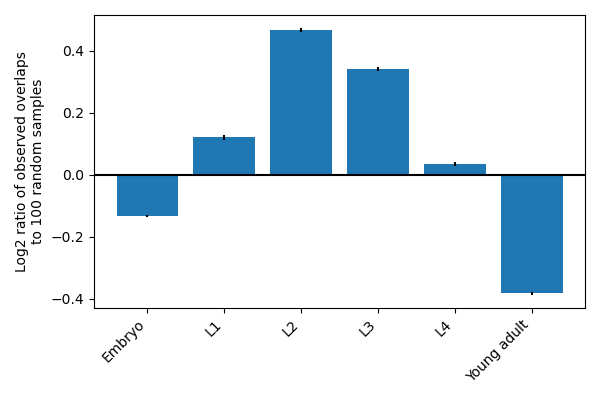

In [93]:
atac_by_stage_sci_arr = numpy.array(atac_by_stage_sci)[:,0]
atac_by_stage_total_arr = numpy.array(atac_by_stage_sci)[:,1]
non_overlap = atac_by_stage_total_arr - atac_by_stage_sci_arr

samples = numpy.random.choice(numpy.arange(atac_by_stage_sci_arr.shape[0]), 
                              size=(100, numpy.sum(atac_by_stage_sci_arr)),
                              replace=True,
                              p=atac_by_stage_total_arr/numpy.sum(atac_by_stage_total_arr))
samples = numpy.hstack([numpy.sum(samples == elt, axis=1)[:,None] 
                        for elt in range(atac_by_stage_sci_arr.shape[0])])

ratios = numpy.log2((atac_by_stage_sci_arr/samples))
mean_ratio = numpy.mean(ratios, axis=0)

ratios_sem = stats.sem(ratios, axis=0)
conf_int = numpy.array([stats.t.interval(0.95, ratios.shape[0]-1, 
                                         loc=mean_ratio[idx], scale=ratios_sem[idx])
                        for idx in range(ratios.shape[1])]).T
conf_int[0] = mean_ratio - conf_int[0]
conf_int[1] = conf_int[1] - mean_ratio

xlocs = numpy.arange(non_overlap.shape[0])
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4))
axes.bar(xlocs, mean_ratio, yerr=conf_int)
axes.axhline(0,color='k')
axes.set_xticks(xlocs)
axes.set_xticklabels(['Embryo', 'L1', 'L2', 'L3', 'L4', 'Young adult'], ha='right', rotation=45)
axes.set_ylabel('Log2 ratio of observed overlaps\nto 100 random samples')
fig.tight_layout()

In [28]:
janes_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/TSS/'
             'janes2018/janes2018_fig2_data1_v2.all_ce11_coords.merged.bed')
total = wc('-l', peaks_merge).strip().split()[0]
cmd = (bedtools['intersect', '-u', '-a', peaks_merge, '-b', janes_bed] 
       | wc['-l'])
sci_janes = (int(cmd().strip()), int(total))
print('ATAC peaks overlapping Janes 2019 peaks: {!s}/{!s}'.format(*sci_janes))

total = wc('-l', janes_bed).strip().split()[0]
cmd = (bedtools['intersect', '-u', '-b', peaks_merge, '-a', janes_bed] 
       | wc['-l'])
janes_sci = (int(cmd().strip()), int(total))
print('Janes 2019 peaks overlapping ATAC peaks: {!s}/{!s}'.format(*janes_sci))

ATAC peaks overlapping Janes 2019 peaks: 25675/38017
Janes 2019 peaks overlapping ATAC peaks: 29021/42102


In [29]:
janes_enhancers = ('ATAC_sequencing/2018_worm_atac/ref_data/TSS/'
                   'janes2018/janes2018_fig2_data1_v2.ce11.enhancers.merged.bed')
sci_total = wc('-l', peaks_merge).strip().split()[0]
cmd = (bedtools['intersect', '-u', '-a', peaks_merge, '-b', janes_enhancers] 
       | wc['-l'])
sci_janes_enh = (int(cmd().strip()), int(sci_total))
print('ATAC peaks overlapping Janes 2019 enhancers: {!s}/{!s}'.format(*sci_janes_enh))

janes_enh_total = wc('-l', janes_enhancers).strip().split()[0]
cmd = (bedtools['intersect', '-u', '-b', peaks_merge, '-a', janes_enhancers] 
       | wc['-l'])
janes_enh_sci = (int(cmd().strip()), int(janes_enh_total))
print('Janes 2019 enhancers overlapping ATAC peaks: {!s}/{!s}'.format(*janes_enh_sci))

ATAC peaks overlapping Janes 2019 enhancers: 12960/38017
Janes 2019 enhancers overlapping ATAC peaks: 13715/19195


In [30]:
janes_promoters = ('ATAC_sequencing/2018_worm_atac/ref_data/TSS/'
                   'janes2018/janes2018_fig2_data1_v2.ce11.promoters.merged.bed')
sci_total = wc('-l', peaks_merge).strip().split()[0]
cmd = (bedtools['intersect', '-u', '-a', peaks_merge, '-b', janes_promoters] 
       | wc['-l'])
sci_janes_prom = (int(cmd().strip()), int(sci_total))
print('ATAC peaks overlapping Janes 2019 promoters: {!s}/{!s}'.format(*sci_janes_prom))

janes_prom_total = wc('-l', janes_promoters).strip().split()[0]
cmd = (bedtools['intersect', '-u', '-b', peaks_merge, '-a', janes_promoters] 
       | wc['-l'])
janes_prom_sci = (int(cmd().strip()), int(janes_prom_total))
print('Janes 2019 promoters overlapping ATAC summits: {!s}/{!s}'.format(*janes_prom_sci))

ATAC peaks overlapping Janes 2019 promoters: 10219/38017
Janes 2019 promoters overlapping ATAC summits: 10684/13833


In [31]:
sci_other, sci_other_totals = zip(sci_tfs, sci_janes, sci_janes_enh, sci_janes_prom)
other_sci, other_sci_totals = zip(tfs_sci, janes_sci, janes_enh_sci, janes_prom_sci)

#xlocs = numpy.arange(2)

#fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(10,6))
to_plot = (numpy.array(sci_other_totals) - numpy.array(sci_other))[:2]

print('No overlap', to_plot)
print('ChIP TF overlapping', sci_other[0])
print('Enh overlapping', sci_other[2])
print('Prom overlapping', sci_other[3])
print('Other overlapping', sci_other_totals[1] - (to_plot[1] + sci_other[2] + sci_other[3]))
print('')

#axes[0].bar(xlocs, to_plot, color='k', label='No overlap')
#axes[0].bar(xlocs[0], sci_other[0], bottom=to_plot[0], color='red', label='ChIP TF overlapping')
#axes[0].bar(xlocs[1], sci_other[2], bottom=to_plot[1], color='blue', label='Enh overlapping')
#axes[0].bar(xlocs[1], sci_other[3], bottom=to_plot[1] + sci_other[2], color='green', label='Prom overlapping')
#axes[0].bar(xlocs[1], sci_other_totals[1] - (to_plot[1] + sci_other[2] + sci_other[3]), 
#            bottom=to_plot[1] + sci_other[2] + sci_other[3], color='orange', label='Other overlapping')
#axes[0].set_xticks(xlocs)
#axes[0].set_xticklabels(['ChIP-seq TF\npeaks', 
#                         'Bulk ATAC-seq\npeaks'], rotation=0)
##                         ha='right')
#axes[0].set_ylabel('sciATAC-seq peak counts', fontsize=14)
#axes[0].set_ylim((0,100000))
##axes[0].legend(bbox_to_anchor=(0.6,1.0))
#axes[0].legend(loc='best', fontsize=10)
#axes[0].set_title('sciATAC-seq overlapping other data')

to_plot = (numpy.array(other_sci_totals) - numpy.array(other_sci))

print('ChIP TF no overlap', to_plot[0])
print('Singleton ChIP site', to_plot[0] - (tfs_neq1_sci[1] - tfs_neq1_sci[0]))
print('Overlapping ChIP TF', other_sci[0])
print('Singleton ChIP site', other_sci[0] - tfs_neq1_sci[0])
print('Enh no overlap', to_plot[2])
print('Prom no overlap', to_plot[3])
print('Other no overlap', other_sci_totals[1] - ((other_sci[1] - other_sci[2] - other_sci[3]) 
                                                 + other_sci_totals[2] + other_sci_totals[3]))
print('Overlapping enh', other_sci[2])
print('Overlapping prom', other_sci[3])
print('Overlapping other', other_sci[1] - (other_sci[2] + other_sci[3]))

#axes[1].bar(xlocs[0], to_plot[0], color='k', label='ChIP TF no overlap')
#axes[1].bar(xlocs[0], to_plot[0] - (tfs_neq1_sci[1] - tfs_neq1_sci[0]), color='k', hatch='//', edgecolor='white',
#            label='Singleton ChIP site')
#axes[1].bar(xlocs[0], other_sci[0], bottom=to_plot[0], color='r', label='Overlapping ChIP TF')
#axes[1].bar(xlocs[0], other_sci[0] - tfs_neq1_sci[0], bottom=to_plot[0], color='r', hatch='//', edgecolor='white',
#            label='Singleton ChIP site')

#axes[1].bar(xlocs[1], to_plot[2], color='darkblue', label='Enh no overlap', hatch='//')
#axes[1].bar(xlocs[1], to_plot[3], bottom=to_plot[2], color='darkgreen', label='Prom no overlap', hatch='//')
#axes[1].bar(xlocs[1], other_sci_totals[1] - ((other_sci[1] - other_sci[2] - other_sci[3]) + other_sci_totals[2] + other_sci_totals[3]),
#            bottom=to_plot[2] + to_plot[3], color='darkorange', label='Other no overlap', hatch='//')
#axes[1].bar(xlocs[1], other_sci[2], bottom=to_plot[1], color='b', label='Overlapping enh')
#axes[1].bar(xlocs[1], other_sci[3], bottom=to_plot[1] + other_sci[2], color='g', label='Overlapping prom')
#axes[1].bar(xlocs[1], other_sci[1] - (other_sci[2] + other_sci[3]), 
#            bottom=to_plot[1] + other_sci[2] + other_sci[3], color='orange', label='Overlapping other')

#axes[1].set_xticks(xlocs)
#axes[1].set_xticklabels(['ChIP-seq TF\npeaks', 
#                         'Bulk ATAC-seq\npeaks'], rotation=0)
##                         ha='right')
#axes[1].set_ylabel('Other data set locus counts', fontsize=14)
#axes[1].set_ylim((0,100000))
#axes[1].legend(loc='best', fontsize=10)
#axes[1].set_title('Other data overlapping sciATAC-seq')
#fig.tight_layout()

No overlap [ 7131 12342]
ChIP TF overlapping 30886
Enh overlapping 12960
Prom overlapping 10219
Other overlapping 2496

ChIP TF no overlap 17679
Singleton ChIP site 13579
Overlapping ChIP TF 23863
Singleton ChIP site 13327
Enh no overlap 5480
Prom no overlap 3149
Other no overlap 4452
Overlapping enh 13715
Overlapping prom 10684
Overlapping other 4622


<IPython.core.display.Javascript object>


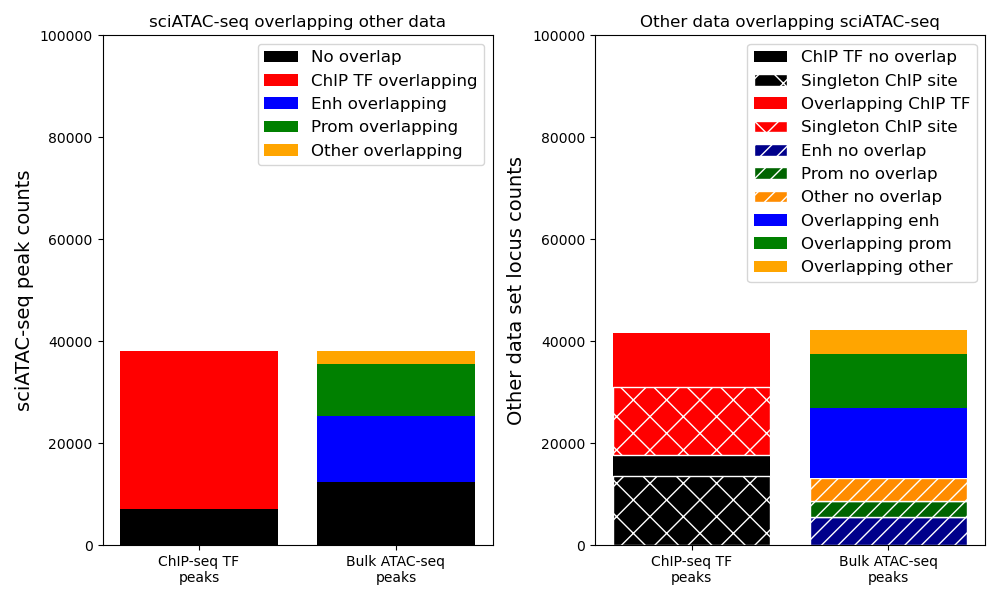

In [32]:
sci_other, sci_other_totals = zip(sci_tfs, sci_janes, sci_janes_enh, sci_janes_prom)
other_sci, other_sci_totals = zip(tfs_sci, janes_sci, janes_enh_sci, janes_prom_sci)

xlocs = numpy.arange(2)

fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(10,6))
to_plot = (numpy.array(sci_other_totals) - numpy.array(sci_other))[:2]
axes[0].bar(xlocs, to_plot, color='k', label='No overlap')
axes[0].bar(xlocs[0], sci_other[0], bottom=to_plot[0], color='red', label='ChIP TF overlapping')
axes[0].bar(xlocs[1], sci_other[2], bottom=to_plot[1], color='blue', label='Enh overlapping')
axes[0].bar(xlocs[1], sci_other[3], bottom=to_plot[1] + sci_other[2], color='green', label='Prom overlapping')
axes[0].bar(xlocs[1], sci_other_totals[1] - (to_plot[1] + sci_other[2] + sci_other[3]), 
            bottom=to_plot[1] + sci_other[2] + sci_other[3], color='orange', label='Other overlapping')
axes[0].set_xticks(xlocs)
axes[0].set_xticklabels(['ChIP-seq TF\npeaks', 
                         'Bulk ATAC-seq\npeaks'], rotation=0)
#                         ha='right')
axes[0].set_ylabel('sciATAC-seq peak counts', fontsize=14)
axes[0].set_ylim((0,100000))
#axes[0].legend(bbox_to_anchor=(0.6,1.0))
axes[0].legend(loc='best', fontsize=12)
axes[0].set_title('sciATAC-seq overlapping other data')

to_plot = (numpy.array(other_sci_totals) - numpy.array(other_sci))
axes[1].bar(xlocs[0], to_plot[0], color='k', label='ChIP TF no overlap')
axes[1].bar(xlocs[0], to_plot[0] - (tfs_neq1_sci[1] - tfs_neq1_sci[0]), color='k', hatch='x', edgecolor='white',
            label='Singleton ChIP site')
axes[1].bar(xlocs[0], other_sci[0], bottom=to_plot[0], color='r', label='Overlapping ChIP TF')
axes[1].bar(xlocs[0], other_sci[0] - tfs_neq1_sci[0], bottom=to_plot[0], color='r', hatch='x', edgecolor='white',
            label='Singleton ChIP site')

axes[1].bar(xlocs[1], to_plot[2], color='darkblue', label='Enh no overlap', hatch='//', edgecolor='white')
axes[1].bar(xlocs[1], to_plot[3], bottom=to_plot[2], color='darkgreen', label='Prom no overlap', hatch='//', edgecolor='white')
axes[1].bar(xlocs[1], other_sci_totals[1] - ((other_sci[1] - other_sci[2] - other_sci[3]) + other_sci_totals[2] + other_sci_totals[3]),
            bottom=to_plot[2] + to_plot[3], color='darkorange', label='Other no overlap', hatch='//', edgecolor='white')
axes[1].bar(xlocs[1], other_sci[2], bottom=to_plot[1], color='b', label='Overlapping enh')
axes[1].bar(xlocs[1], other_sci[3], bottom=to_plot[1] + other_sci[2], color='g', label='Overlapping prom')
axes[1].bar(xlocs[1], other_sci[1] - (other_sci[2] + other_sci[3]), 
            bottom=to_plot[1] + other_sci[2] + other_sci[3], color='orange', label='Overlapping other')

axes[1].set_xticks(xlocs)
axes[1].set_xticklabels(['ChIP-seq TF\npeaks', 
                         'Bulk ATAC-seq\npeaks'], rotation=0)
#                         ha='right')
axes[1].set_ylabel('Other data set locus counts', fontsize=14)
axes[1].set_ylim((0,100000))
axes[1].legend(loc='best', fontsize=12)
axes[1].set_title('Other data overlapping sciATAC-seq')
fig.tight_layout()

## Check for the number of overlaps between topic-specific peaks and these other data sets

In [33]:
frac_peaks_w_chip_overlap = numpy.divide(*sci_tfs)
print(frac_peaks_w_chip_overlap)

frac_peaks_w_atac_overlap = numpy.divide(*sci_janes)
print(frac_peaks_w_atac_overlap)

0.8124260199384485
0.6753557618959939


In [34]:
tf_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
          'WS245/annotatedPeak.20190420.merged.bed')
#peaks_merge = ('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
#               'all_lda1_peaks.scored_filtered_merged_colored.tissue_merged.overlaps_merged_for_lda.bed')
#peaks_merge = ('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
#               'topic_analysis/rank_peaks/topic_analysis/test_merge_and_expand/all_summits_expanded2.merged.expanded2.bed')
peaks_list = sorted(glob.glob('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
                              'topic_analysis/rank_peaks/topic_mode_top_topic_peaks_sorted_filtered_topics/*.bed'))
topic_nums = []
topic_ranks = []
top_peaks_w_chip_overlap = []
for peaks_path in peaks_list:
    topic_ranks.append(int(os.path.basename(peaks_path).split('.')[1].lstrip('rank')))
    topic_nums.append(int(os.path.basename(peaks_path).split('.')[0].lstrip('topic')))
    print(os.path.basename(peaks_path))
    sci_total = wc('-l', peaks_path).strip().split()[0]
    cmd = bedtools['intersect', '-u', '-a', peaks_path, '-b', tf_bed] | wc['-l']
    sci_tfs = (int(cmd().strip()), int(sci_total))
    top_peaks_w_chip_overlap.append(sci_tfs)
    print('ATAC peaks overlapping TF peaks: {!s}/{!s}'.format(*sci_tfs))

    tf_total = wc('-l', tf_bed).strip().split()[0]
    cmd = bedtools['intersect', '-u', '-b', peaks_path, '-a', tf_bed] | wc['-l']
    tfs_sci = (int(cmd().strip()), int(tf_total))
    print('TF peaks overlapping ATAC peaks: {!s}/{!s}'.format(*tfs_sci))
    print()

topic0.rank12.bed
ATAC peaks overlapping TF peaks: 209/250
TF peaks overlapping ATAC peaks: 237/41542

topic1.rank2.bed
ATAC peaks overlapping TF peaks: 229/250
TF peaks overlapping ATAC peaks: 319/41542

topic10.rank21.bed
ATAC peaks overlapping TF peaks: 174/250
TF peaks overlapping ATAC peaks: 213/41542

topic12.rank18.bed
ATAC peaks overlapping TF peaks: 150/250
TF peaks overlapping ATAC peaks: 169/41542

topic13.rank29.bed
ATAC peaks overlapping TF peaks: 215/250
TF peaks overlapping ATAC peaks: 249/41542

topic14.rank9.bed
ATAC peaks overlapping TF peaks: 169/250
TF peaks overlapping ATAC peaks: 185/41542

topic15.rank4.bed
ATAC peaks overlapping TF peaks: 184/250
TF peaks overlapping ATAC peaks: 219/41542

topic16.rank15.bed
ATAC peaks overlapping TF peaks: 153/250
TF peaks overlapping ATAC peaks: 162/41542

topic17.rank17.bed
ATAC peaks overlapping TF peaks: 205/250
TF peaks overlapping ATAC peaks: 296/41542

topic18.rank26.bed
ATAC peaks overlapping TF peaks: 116/250
TF peaks 

In [12]:
tf_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
          'WS245/annotatedPeak.20190420.merged.bed')
#peaks_merge = ('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
#               'all_lda1_peaks.scored_filtered_merged_colored.tissue_merged.overlaps_merged_for_lda.bed')
#peaks_merge = ('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
#               'topic_analysis/rank_peaks/topic_analysis/test_merge_and_expand/all_summits_expanded2.merged.expanded2.bed')
peaks_list = sorted(glob.glob('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
                              'tissue_analysis/*/topic_analysis/rank_peaks/topic_mode_top_topic_peaks_sorted_filtered_topics/*.bed'))
for peaks_path in peaks_list:
    print(os.path.basename(peaks_path))
    sci_total = wc('-l', peaks_path).strip().split()[0]
    cmd = bedtools['intersect', '-u', '-a', peaks_path, '-b', tf_bed] | wc['-l']
    sci_tfs = (int(cmd().strip()), int(sci_total))
    print('ATAC peaks overlapping TF peaks: {!s}/{!s}'.format(*sci_tfs))

    tf_total = wc('-l', tf_bed).strip().split()[0]
    cmd = bedtools['intersect', '-u', '-b', peaks_path, '-a', tf_bed] | wc['-l']
    tfs_sci = (int(cmd().strip()), int(tf_total))
    print('TF peaks overlapping ATAC peaks: {!s}/{!s}'.format(*tfs_sci))
    print()

topic0.rank1.bed
ATAC peaks overlapping TF peaks: 706/883
TF peaks overlapping ATAC peaks: 692/41542

topic2.rank0.bed
ATAC peaks overlapping TF peaks: 592/640
TF peaks overlapping ATAC peaks: 586/41542

topic0.rank0.bed
ATAC peaks overlapping TF peaks: 280/411
TF peaks overlapping ATAC peaks: 314/41542

topic2.rank2.bed
ATAC peaks overlapping TF peaks: 255/301
TF peaks overlapping ATAC peaks: 268/41542

topic3.rank5.bed
ATAC peaks overlapping TF peaks: 322/447
TF peaks overlapping ATAC peaks: 336/41542

topic4.rank3.bed
ATAC peaks overlapping TF peaks: 303/364
TF peaks overlapping ATAC peaks: 306/41542

topic6.rank1.bed
ATAC peaks overlapping TF peaks: 559/843
TF peaks overlapping ATAC peaks: 579/41542

topic7.rank6.bed
ATAC peaks overlapping TF peaks: 363/443
TF peaks overlapping ATAC peaks: 377/41542

topic8.rank4.bed
ATAC peaks overlapping TF peaks: 327/430
TF peaks overlapping ATAC peaks: 345/41542

topic0.rank0.bed
ATAC peaks overlapping TF peaks: 2209/2362
TF peaks overlapping A

In [13]:
tf_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
          'WS245/annotatedPeak.20190420.merged.bed')
#peaks_merge = ('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
#               'all_lda1_peaks.scored_filtered_merged_colored.tissue_merged.overlaps_merged_for_lda.bed')
#peaks_merge = ('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
#               'topic_analysis/rank_peaks/topic_analysis/test_merge_and_expand/all_summits_expanded2.merged.expanded2.bed')
peaks_glob = glob.glob('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
                       'topic_analysis/rank_peaks/topic_mode_top_topic_peaks_sorted_filtered_topics/*.bed')
sci_total = (local['cat'].__getitem__(peaks_glob) | wc['-l'])().strip().split()[0]
cmd = local['cat'].__getitem__(peaks_glob) | bedtools['intersect', '-u', '-a', 'stdin', '-b', tf_bed] | wc['-l']
sci_tfs = (int(cmd().strip()), int(sci_total))
print('ATAC peaks overlapping TF peaks: {!s}/{!s}'.format(*sci_tfs))

tf_total = wc('-l', tf_bed).strip().split()[0]
cmd = local['cat'].__getitem__(peaks_glob) | bedtools['intersect', '-u', '-b', 'stdin', '-a', tf_bed] | wc['-l']
tfs_sci = (int(cmd().strip()), int(tf_total))
print('TF peaks overlapping ATAC peaks: {!s}/{!s}'.format(*tfs_sci))

ATAC peaks overlapping TF peaks: 6562/9250
TF peaks overlapping ATAC peaks: 7405/41542


In [35]:
janes_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/TSS/'
             'janes2018/janes2018_fig2_data1_v2.all_ce11_coords.merged.bed')
peaks_list = sorted(glob.glob('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
                              'topic_analysis/rank_peaks/topic_mode_top_topic_peaks_sorted_filtered_topics/*.bed'))
janes_total = wc('-l', janes_bed).strip().split()[0]

topic_nums_janes = []
topic_ranks_janes = []
top_peaks_w_janes_overlap = []
for peaks_path in peaks_list:
    topic_ranks_janes.append(int(os.path.basename(peaks_path).split('.')[1].lstrip('rank')))
    topic_nums_janes.append(int(os.path.basename(peaks_path).split('.')[0].lstrip('topic')))
    print(os.path.basename(peaks_path))
    sci_total = wc('-l', peaks_path).strip().split()[0]
    cmd = (bedtools['intersect', '-u', '-a', peaks_path, '-b', janes_bed] 
           | wc['-l'])
    sci_janes = (int(cmd().strip()), int(sci_total))
    top_peaks_w_janes_overlap.append(sci_janes)
    print('ATAC peaks overlapping Janes 2019 peaks: {!s}/{!s}'.format(*sci_janes))
    print()

topic0.rank12.bed
ATAC peaks overlapping Janes 2019 peaks: 86/250

topic1.rank2.bed
ATAC peaks overlapping Janes 2019 peaks: 242/250

topic10.rank21.bed
ATAC peaks overlapping Janes 2019 peaks: 114/250

topic12.rank18.bed
ATAC peaks overlapping Janes 2019 peaks: 135/250

topic13.rank29.bed
ATAC peaks overlapping Janes 2019 peaks: 193/250

topic14.rank9.bed
ATAC peaks overlapping Janes 2019 peaks: 93/250

topic15.rank4.bed
ATAC peaks overlapping Janes 2019 peaks: 136/250

topic16.rank15.bed
ATAC peaks overlapping Janes 2019 peaks: 44/250

topic17.rank17.bed
ATAC peaks overlapping Janes 2019 peaks: 214/250

topic18.rank26.bed
ATAC peaks overlapping Janes 2019 peaks: 75/250

topic19.rank19.bed
ATAC peaks overlapping Janes 2019 peaks: 32/250

topic21.rank8.bed
ATAC peaks overlapping Janes 2019 peaks: 170/250

topic23.rank30.bed
ATAC peaks overlapping Janes 2019 peaks: 194/250

topic24.rank3.bed
ATAC peaks overlapping Janes 2019 peaks: 172/250

topic25.rank14.bed
ATAC peaks overlapping Jane

In [15]:
janes_enhancers = ('ATAC_sequencing/2018_worm_atac/ref_data/TSS/'
                   'janes2018/janes2018_fig2_data1_v2.ce11.enhancers.merged.bed')
janes_promoters = ('ATAC_sequencing/2018_worm_atac/ref_data/TSS/'
                   'janes2018/janes2018_fig2_data1_v2.ce11.promoters.merged.bed')
peaks_list = sorted(glob.glob('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
                              'topic_analysis/rank_peaks/topic_mode_top_topic_peaks_sorted_filtered_topics/*.bed'))
sci_total = wc('-l', peaks_path).strip().split()[0]
janes_enh_total = wc('-l', janes_enhancers).strip().split()[0]
janes_prom_total = wc('-l', janes_promoters).strip().split()[0]
for peaks_path in peaks_list:
    print(os.path.basename(peaks_path))
    cmd = (bedtools['intersect', '-u', '-a', peaks_path, '-b', janes_enhancers] 
           | wc['-l'])
    sci_janes_enh = (int(cmd().strip()), int(sci_total))
    print('ATAC peaks overlapping Janes 2019 enhancers: {!s}/{!s}'.format(*sci_janes_enh))
    cmd = (bedtools['intersect', '-u', '-a', peaks_path, '-b', janes_promoters] 
           | wc['-l'])
    sci_janes_prom = (int(cmd().strip()), int(sci_total))
    print('ATAC peaks overlapping Janes 2019 promoters: {!s}/{!s}'.format(*sci_janes_prom))
    cmd = (bedtools['intersect', '-u', '-a', peaks_path, '-b', janes_promoters, '-b', janes_enhancers] 
           | wc['-l'])
    sci_janes_prom = (int(cmd().strip()), int(sci_total))
    print('ATAC peaks overlapping Janes 2019 peaks: {!s}/{!s}'.format(*sci_janes_prom))

    cmd = (bedtools['intersect', '-u', '-b', peaks_path, '-a', janes_enhancers] 
           | wc['-l'])
    janes_enh_sci = (int(cmd().strip()), int(janes_enh_total))
    print('Janes 2019 enhancers overlapping ATAC peaks: {!s}/{!s}'.format(*janes_enh_sci))
    
    cmd = (bedtools['intersect', '-u', '-b', peaks_path, '-a', janes_promoters] 
           | wc['-l'])
    janes_prom_sci = (int(cmd().strip()), int(janes_prom_total))
    print('Janes 2019 promoters overlapping ATAC summits: {!s}/{!s}'.format(*janes_prom_sci))
    print()

topic0.rank12.bed
ATAC peaks overlapping Janes 2019 enhancers: 51/250
ATAC peaks overlapping Janes 2019 promoters: 23/250
ATAC peaks overlapping Janes 2019 peaks: 71/250
Janes 2019 enhancers overlapping ATAC peaks: 62/19195
Janes 2019 promoters overlapping ATAC summits: 24/13833

topic1.rank2.bed
ATAC peaks overlapping Janes 2019 enhancers: 121/250
ATAC peaks overlapping Janes 2019 promoters: 138/250
ATAC peaks overlapping Janes 2019 peaks: 216/250
Janes 2019 enhancers overlapping ATAC peaks: 162/19195
Janes 2019 promoters overlapping ATAC summits: 157/13833

topic10.rank21.bed
ATAC peaks overlapping Janes 2019 enhancers: 66/250
ATAC peaks overlapping Janes 2019 promoters: 46/250
ATAC peaks overlapping Janes 2019 peaks: 104/250
Janes 2019 enhancers overlapping ATAC peaks: 81/19195
Janes 2019 promoters overlapping ATAC summits: 54/13833

topic12.rank18.bed
ATAC peaks overlapping Janes 2019 enhancers: 74/250
ATAC peaks overlapping Janes 2019 promoters: 50/250
ATAC peaks overlapping Janes

ATAC peaks overlapping Janes 2019 peaks: 136/250
Janes 2019 enhancers overlapping ATAC peaks: 126/19195
Janes 2019 promoters overlapping ATAC summits: 88/13833

topic47.rank34.bed
ATAC peaks overlapping Janes 2019 enhancers: 63/250
ATAC peaks overlapping Janes 2019 promoters: 108/250
ATAC peaks overlapping Janes 2019 peaks: 155/250
Janes 2019 enhancers overlapping ATAC peaks: 75/19195
Janes 2019 promoters overlapping ATAC summits: 117/13833

topic48.rank35.bed
ATAC peaks overlapping Janes 2019 enhancers: 68/250
ATAC peaks overlapping Janes 2019 promoters: 171/250
ATAC peaks overlapping Janes 2019 peaks: 208/250
Janes 2019 enhancers overlapping ATAC peaks: 75/19195
Janes 2019 promoters overlapping ATAC summits: 210/13833

topic51.rank0.bed
ATAC peaks overlapping Janes 2019 enhancers: 108/250
ATAC peaks overlapping Janes 2019 promoters: 175/250
ATAC peaks overlapping Janes 2019 peaks: 230/250
Janes 2019 enhancers overlapping ATAC peaks: 143/19195
Janes 2019 promoters overlapping ATAC sum

In [16]:
janes_promoters = ('ATAC_sequencing/2018_worm_atac/ref_data/TSS/'
                   'janes2018/janes2018_fig2_data1_v2.ce11.promoters.merged.bed')
sci_total = wc('-l', peaks_merge).strip().split()[0]
cmd = (bedtools['intersect', '-u', '-a', peaks_merge, '-b', janes_promoters] 
       | wc['-l'])
sci_janes_prom = (int(cmd().strip()), int(sci_total))
print('ATAC peaks overlapping Janes 2019 promoters: {!s}/{!s}'.format(*sci_janes_prom))

janes_prom_total = wc('-l', janes_promoters).strip().split()[0]
cmd = (bedtools['intersect', '-u', '-b', peaks_merge, '-a', janes_promoters] 
       | wc['-l'])
janes_prom_sci = (int(cmd().strip()), int(janes_prom_total))
print('Janes 2019 promoters overlapping ATAC summits: {!s}/{!s}'.format(*janes_prom_sci))

ATAC peaks overlapping Janes 2019 promoters: 10219/38017
Janes 2019 promoters overlapping ATAC summits: 10684/13833


<IPython.core.display.Javascript object>


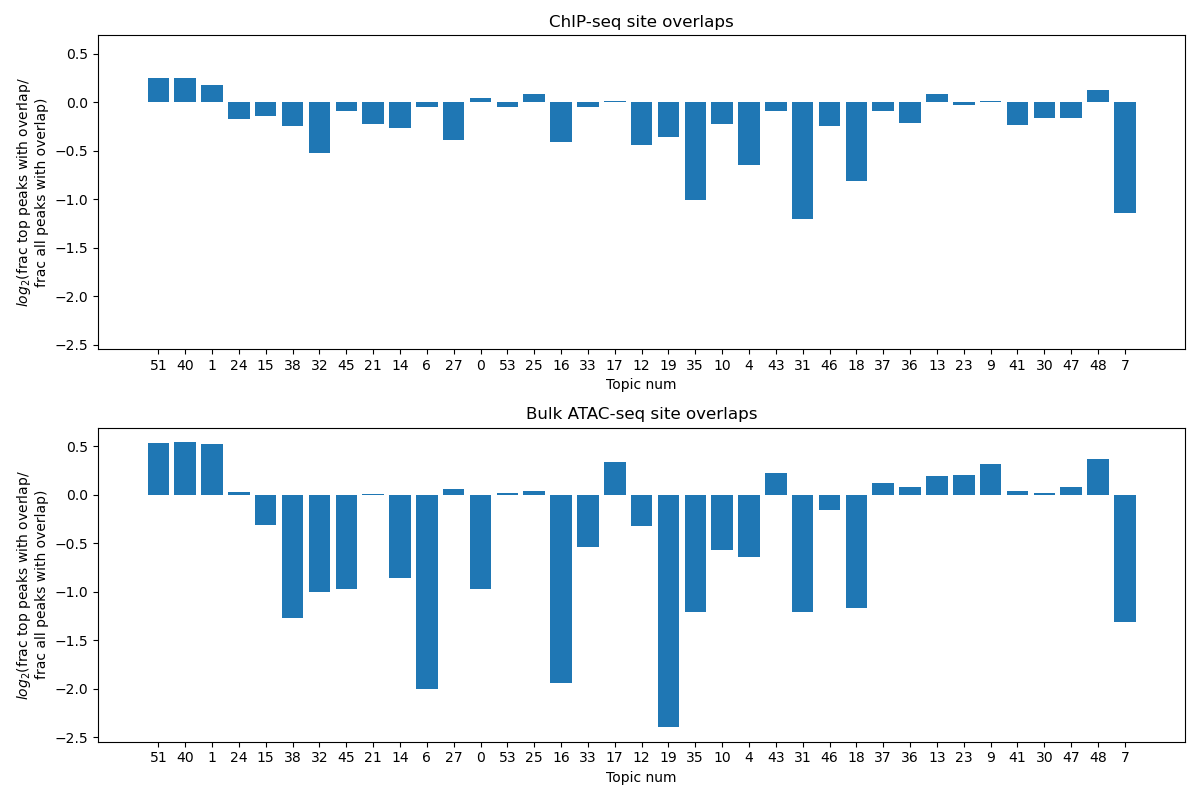

In [36]:
fig, axes = pyplot.subplots(nrows=2, ncols=1, figsize=(12,8), sharey=True)

#topic_nums = []
#top_peaks_w_chip_overlap = []
#frac_peaks_w_chip_overlap = numpy.divide(*sci_tfs)
#frac_peaks_w_atac_overlap = numpy.divide(*sci_janes)
#topic_nums_janes = []
#top_peaks_w_janes_overlap = []

topic_nums = numpy.array(topic_nums)
topic_num_sort = numpy.argsort(topic_ranks)
top_peaks_w_chip_overlap = numpy.array(top_peaks_w_chip_overlap)
frac_top_peaks_w_chip_overlap = top_peaks_w_chip_overlap[:,0]/top_peaks_w_chip_overlap[:,1]
xlocs = numpy.arange(topic_num_sort.shape[0])
to_plot = numpy.log2(frac_top_peaks_w_chip_overlap/frac_peaks_w_chip_overlap)

axes[0].bar(xlocs, to_plot[topic_num_sort])
axes[0].set_xticks(xlocs)
axes[0].set_xticklabels(topic_nums[topic_num_sort])
axes[0].set_xlabel('Topic num')
axes[0].set_ylabel('$log_2$(frac top peaks with overlap/\nfrac all peaks with overlap)')
axes[0].set_title('ChIP-seq site overlaps')

topic_nums_janes = numpy.array(topic_nums_janes)
topic_num_sort = numpy.argsort(topic_ranks_janes)
top_peaks_w_janes_overlap = numpy.array(top_peaks_w_janes_overlap)
frac_top_peaks_w_janes_overlap = top_peaks_w_janes_overlap[:,0]/top_peaks_w_janes_overlap[:,1]
xlocs = numpy.arange(topic_num_sort.shape[0])
to_plot = numpy.log2(frac_top_peaks_w_janes_overlap/frac_peaks_w_atac_overlap)

axes[1].bar(xlocs, to_plot[topic_num_sort])
axes[1].set_xticks(xlocs)
axes[1].set_xticklabels(topic_nums[topic_num_sort])
axes[1].set_xlabel('Topic num')
axes[1].set_ylabel('$log_2$(frac top peaks with overlap/\nfrac all peaks with overlap)')
axes[1].set_title('Bulk ATAC-seq site overlaps')

fig.tight_layout()

## Analyze peak-topic distribution for peaks with and without ChIP site overlaps

In [2]:
#all TF ChIP sites
tf_bed = ('ATAC_sequencing/2018_worm_atac/ref_data/ChIP-seq/'
          'WS245/annotatedPeak.20190420.merged.bed')
#all split (expanded summit) peaks
peaks_merge = ('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/'
               'topic_analysis/rank_peaks/topic_analysis/test_merge_and_expand/all_summits_expanded2.merged.expanded2.bed')
#all peaks used in the LDA model
lda_peaks = ('ATAC_sequencing/all_sciATAC/data_reprocess_ce11/lda_pipeline/topic_analysis/rank_peaks/'
             'filtered_peaks_iqr4.0_low_cells.with_peak_index.bed')

#identify all LDA peaks with a ChIP-seq site overlap
overlaps_cmd = local['bedtools']['intersect', '-a', lda_peaks, '-b', tf_bed, '-u'] | local['cut']['-f4']
overlaps_idx = numpy.array(overlaps_cmd().strip().split(), dtype=int)
print(overlaps_idx.shape)

unique_cmd = local['bedtools']['intersect', '-a', lda_peaks, '-b', tf_bed, '-v'] | local['cut']['-f4']
unique_idx = numpy.array(unique_cmd().strip().split(), dtype=int)
print(unique_idx.shape)

(21561,)
(10653,)


In [3]:
#load wordTopic
peaktopic_path = '../topic_analysis/rank_peaks/0000_topics55_alpha3.000_beta2000.000/topic_mode.wordTopic'
peaktopic = numpy.loadtxt(peaktopic_path, delimiter=',', dtype=float)
print(peaktopic.shape)

#center and scale the topic values
#col_means = numpy.mean(doctopic.T, axis=0)
#doctopic_norm = doctopic.T - col_means
#doctopic_norm = doctopic_norm / numpy.std(doctopic_norm, axis=0)
#doctopic_norm = doctopic_norm.T
#print(doctopic_norm.shape)

nonzero_idx = numpy.where(numpy.sum(peaktopic, axis=1) > 0)[0]
peaktopic = peaktopic[nonzero_idx]

col_means = numpy.mean(peaktopic.T, axis=0)
peaktopic_norm = peaktopic.T - col_means
l2_for_norm = (peaktopic_norm ** 2).sum(axis=0).flatten() ** 0.5
peaktopic_norm /= l2_for_norm
peaktopic_norm = peaktopic_norm.T
print(peaktopic_norm.shape)

peaktopic_frac = (peaktopic.T/peaktopic.sum(axis=1).astype(float)).T
print(peaktopic_frac.shape)

(32214, 55)
(32214, 55)
(32214, 55)


In [5]:
import anndata
cluster_data = anndata.read_loom('../topic_analysis/rank_peaks/lda_analysis.loom')
print(cluster_data)

/net/gs/vol1/home/tdurham/src/anaconda/envs/python3_remake2/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/net/gs/vol1/home/tdurham/src/anaconda/envs/python3_remake2/lib/python3.6/site-packages/loompy/loom_validator.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(path) as f:


AnnData object with n_obs × n_vars = 30870 × 32214 
    obs: 'TopicCluster'
    var: 'PeakID', 'chrom', 'end', 'start'
    obsm: 'theta', 'theta_norm', 'umap10', 'umap2', 'umap3'
    varm: 'peaktopic', 'peaktopic_norm', 'phi', 'phi_norm'


(32214,)
0.6693052710001862 0.6727272727272727
(8.072727272727272, 18.740547588005214)


<IPython.core.display.Javascript object>


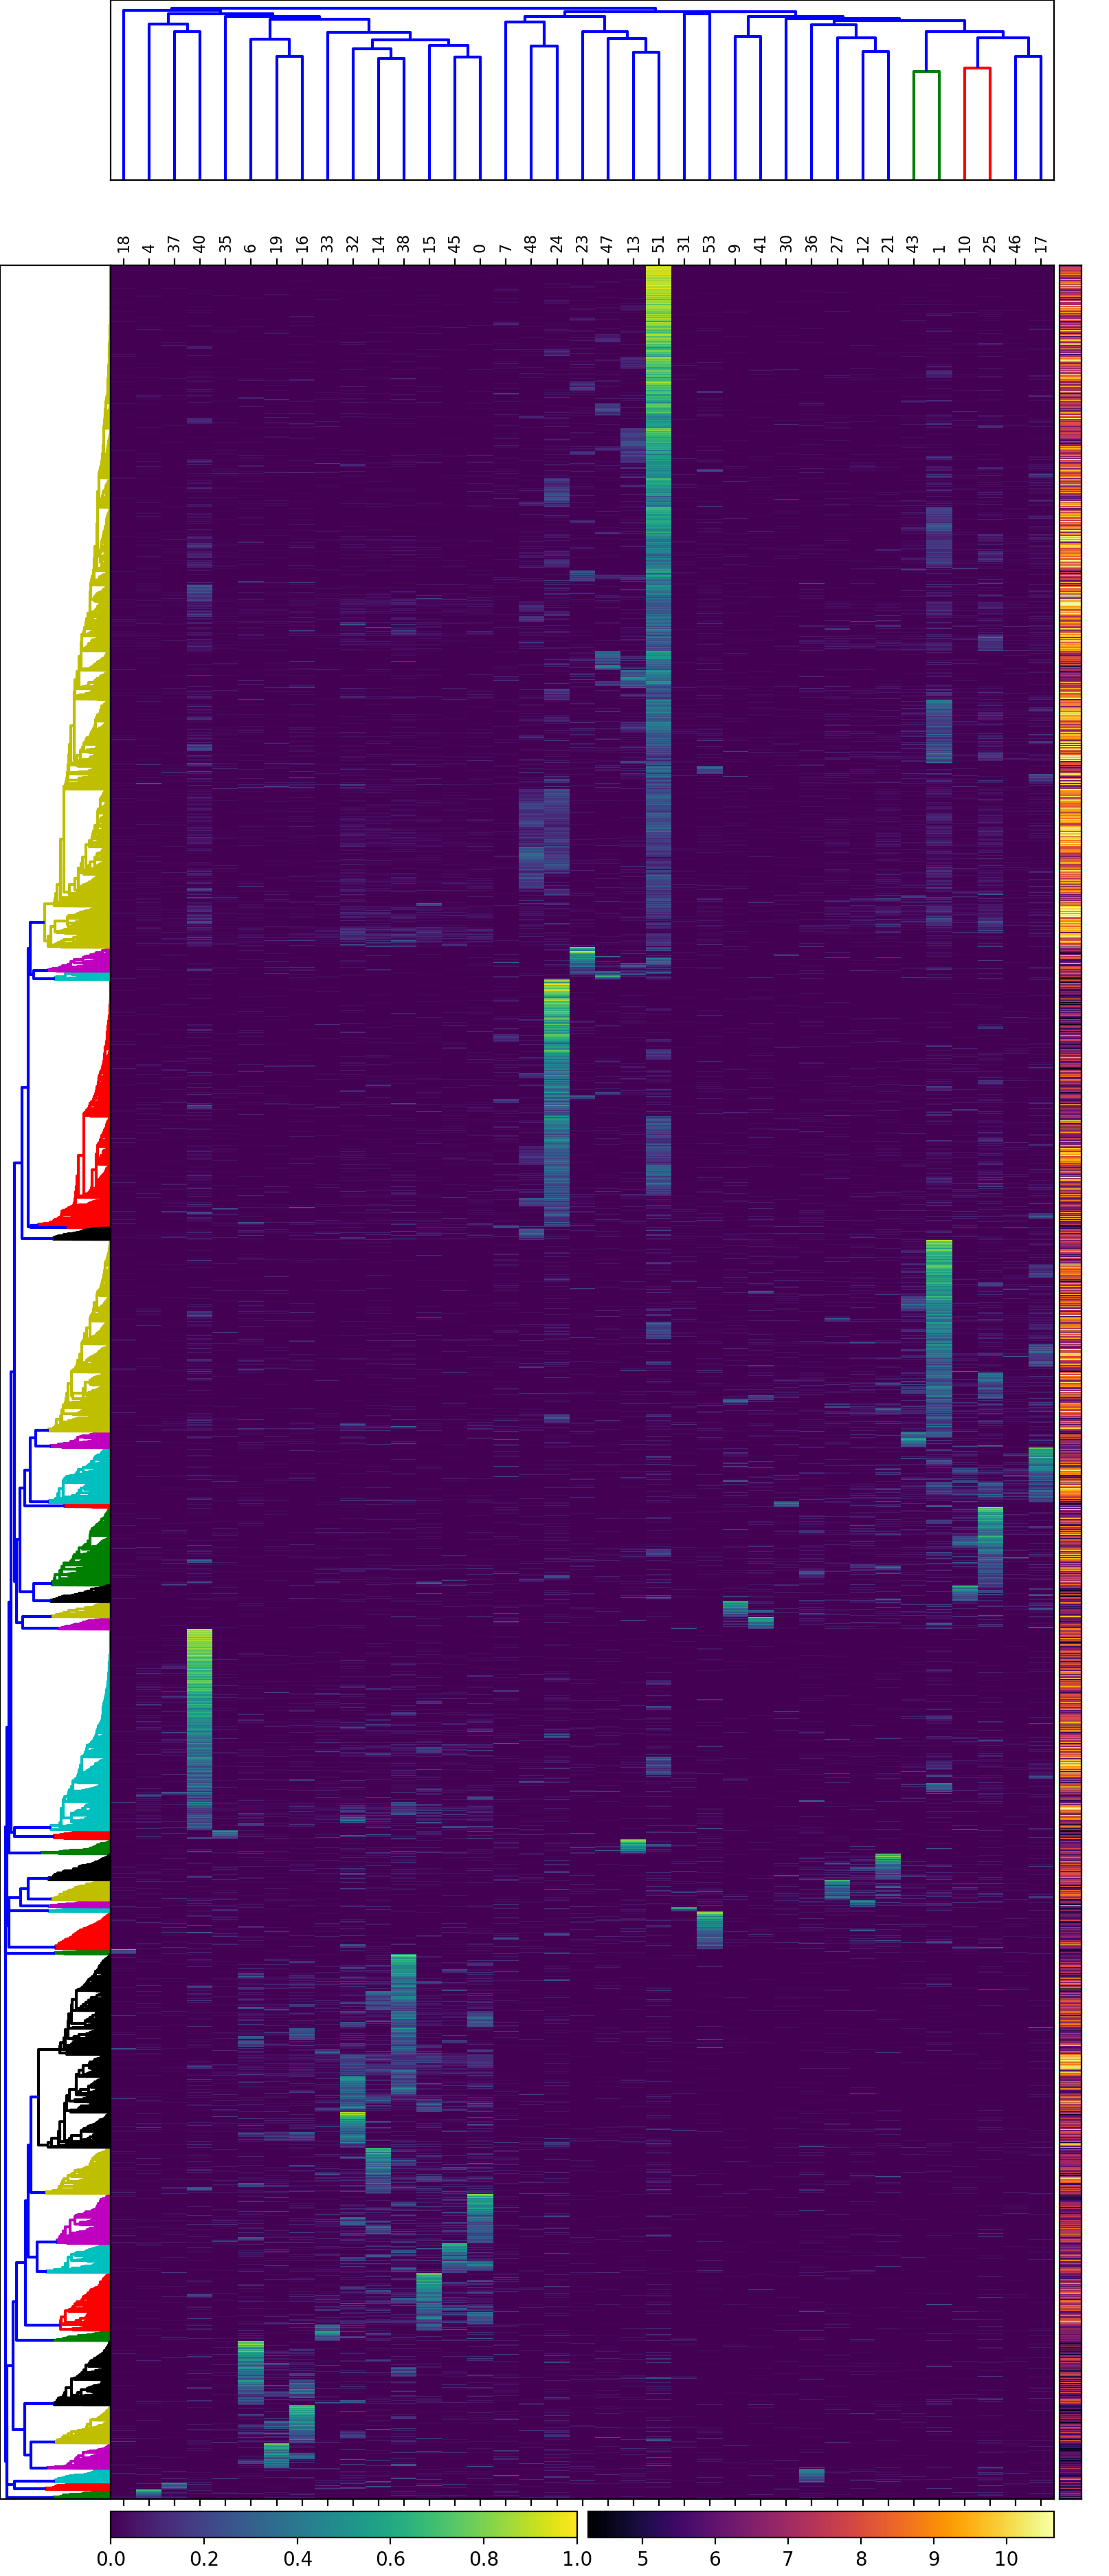

In [23]:
topics_for_clustering = [(0,615), (1, 2588), (4, 286), (6, 405), (7, 20), (9, 79), (10, 416), (12, 321), (13, 155), 
                         (14, 696), (15, 712), (16, 406), (17, 681), (18, 103), (19, 218), (21, 663), (23, 94), 
                         (24, 1653), (25, 1631), (27, 421), (30, 63), (31, 126), (32, 1095), (33, 247),
                        (35, 238), (36, 171), (37, 104), (38, 981), (40, 2328), (41, 86), (43, 468), (45, 399),
                         (46, 216), (47, 67), (48, 24), (51, 4422), (53, 378)]
topics_for_clustering = [elt[0] for elt in sorted(topics_for_clustering, key=lambda x:int(x[1]))]
peak_coverage = numpy.log2(numpy.array(cluster_data.X.sum(axis=0))).flatten()
print(peak_coverage.shape)
to_plot_peaktopic_frac = peaktopic_frac[overlaps_idx][:, topics_for_clustering]
to_plot_peak_coverage = peak_coverage[overlaps_idx]

# axm, placement of heatmap for the data matrix
[axm_x, axm_y, axm_w, axm_h] = [0.1, 0.03, 0.85, 0.867]

# ax1, placement of dendrogram 1, to the left of the heatmap
[ax1_x, ax1_y, ax1_w, ax1_h] = [0, 0.03, 0.1, 0.867]

# ax2, placement of dendrogram 2, on the top of the heatmap
[ax2_x, ax2_y, ax2_w, ax2_h] = [0.1, 0.93, 0.85, 0.07]

# axcov - placement of the cell coverage plot
[axcov_x, axcov_y, axcov_w, axcov_h] = [0.955, 0.03, 0.02, 0.867]

# axcb - placement of the color legend
[axcb_x, axcb_y, axcb_w, axcb_h] = [0.1, 0.015, 0.42, 0.01]

# axcb2 - placement of the coverage plot color legend
[axcb2_x, axcb2_y, axcb2_w, axcb2_h] = [0.53, 0.015, 0.42, 0.01]

master_size = (12,28) + peaktopic_frac.shape
height_factor = to_plot_peaktopic_frac.shape[0]/master_size[2]
width_factor = to_plot_peaktopic_frac.shape[1]/master_size[3]
print(height_factor, width_factor)
print((master_size[0] * width_factor, master_size[1]*height_factor))
fig = pyplot.figure(figsize=(master_size[0] * width_factor, master_size[1]*height_factor))

#plot dendrogram of rows
ax1 = fig.add_axes([ax1_x, ax1_y, ax1_w, ax1_h])
#Note: these were treated as samples by features, not distance matrices...
#dist1 = distance.squareform(distance.pdist(doctopic_norm, metric='cosine'))
dist1 = distance.pdist(to_plot_peaktopic_frac, metric='cosine')
Y1 = hierarchy.linkage(dist1, method='average')
Z1 = hierarchy.dendrogram(Y1, orientation='left', no_labels=True, ax=ax1, count_sort=True)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_yticks([])
ax1.set_yticklabels([])

#plot dendrogram of cols
ax2 = fig.add_axes([ax2_x, ax2_y, ax2_w, ax2_h])
#Note: these were treated as samples by features, not distance matrices...
#dist2 = distance.squareform(distance.pdist(doctopic_norm.T, metric='cosine'))
dist2 = distance.pdist(to_plot_peaktopic_frac.T, metric='cosine')
Y2_nontf = hierarchy.linkage(dist2, method='average')
Z2_nontf = hierarchy.dendrogram(Y2_nontf, orientation='top', no_labels=True, ax=ax2, count_sort=True)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.set_yticks([])
ax2.set_yticklabels([])

#plot heatmap
ax3 = fig.add_axes([axm_x, axm_y, axm_w, axm_h])
h_index1 = Z1['leaves']
h_index2 = Z2_nontf['leaves']
resort_x = to_plot_peaktopic_frac[h_index1,:]
resort_x = resort_x[:,h_index2]
im = ax3.matshow(resort_x, cmap='viridis', aspect='auto', origin='lower')

#for elt in range(0, 10000, 500):
#    ax3.axhline(elt, color='r')

xlocs = numpy.arange(to_plot_peaktopic_frac.shape[1])
ax3.set_xticks(xlocs)
ax3.set_xticklabels(numpy.array(topics_for_clustering)[h_index2], fontsize=8, rotation=90)
ax3.set_yticks([])

#plot cell coverage
axcov = fig.add_axes([axcov_x, axcov_y, axcov_w, axcov_h])
im_cov = axcov.matshow(to_plot_peak_coverage[h_index1,None], vmin=min(peak_coverage), 
                       vmax=max(peak_coverage), cmap='inferno', aspect='auto', origin='lower')
axcov.set_xticks([])
axcov.set_yticks([])

#left, bottom, width, height
cbaxes = fig.add_axes([axcb_x, axcb_y, axcb_w, axcb_h])
cb = fig.colorbar(im, orientation='horizontal', cax=cbaxes)

cbaxes2 = fig.add_axes([axcb2_x, axcb2_y, axcb2_w, axcb2_h])
cb2 = fig.colorbar(im_cov, orientation='horizontal', cax=cbaxes2)

#ax3.set_yticks(numpy.arange(doctopic_norm.shape[0]))
#ax3.set_yticklabels(numpy.array(x_labels)[h_index1])

fig.show()

(32214,)
0.3306947289998137 0.6727272727272727
(8.072727272727272, 9.259452411994785)


<IPython.core.display.Javascript object>


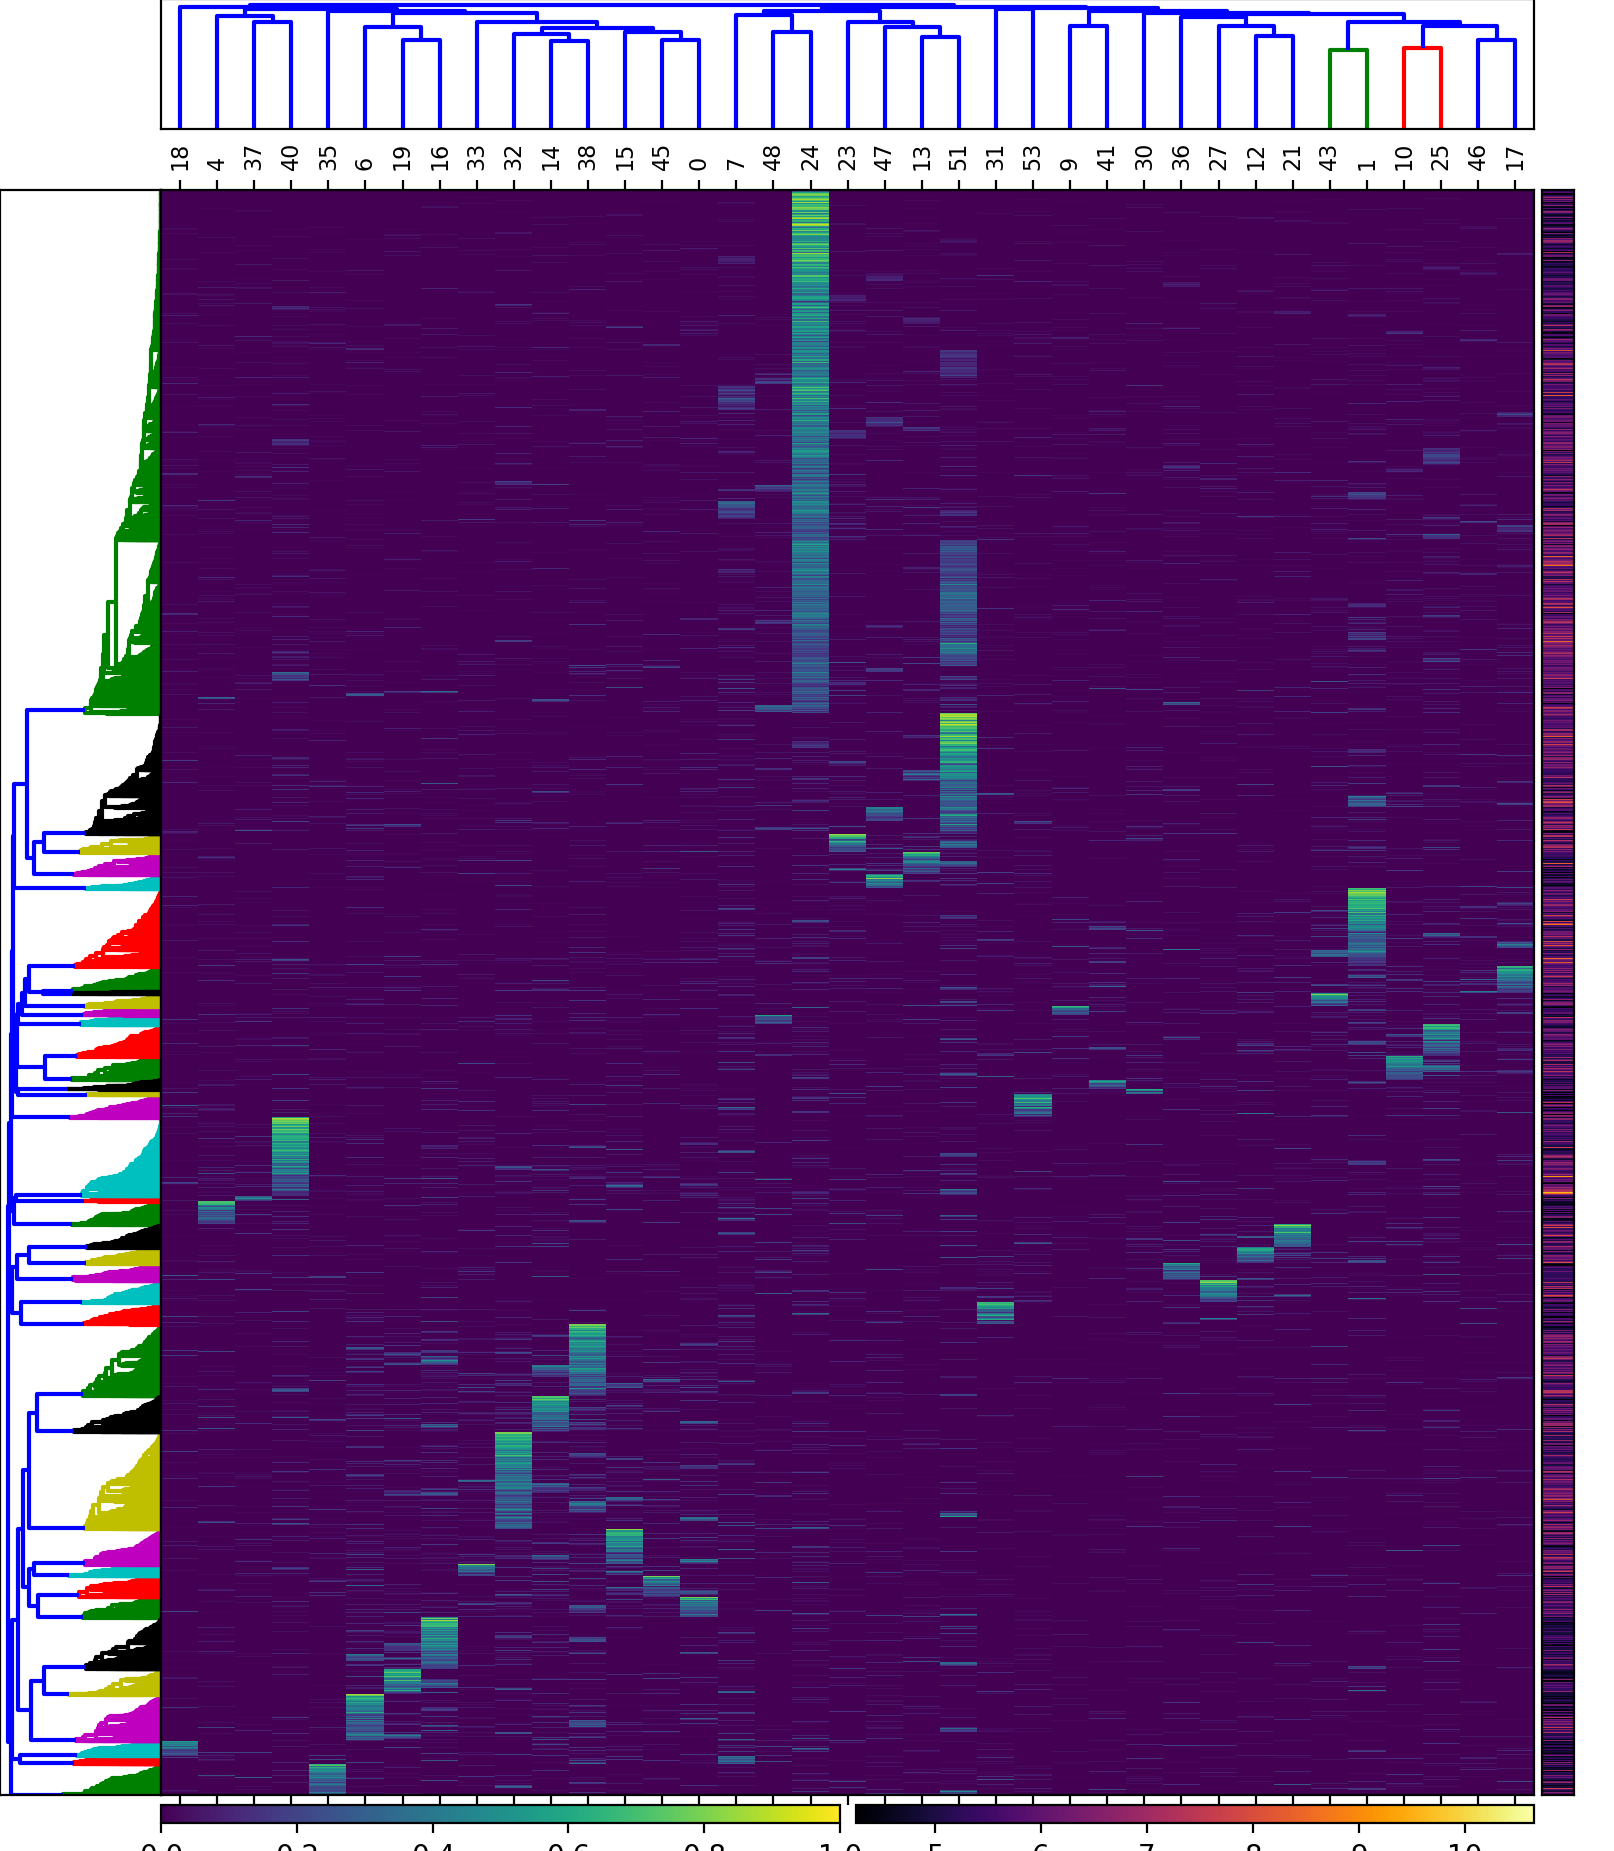

In [24]:
topics_for_clustering = [(0,615), (1, 2588), (4, 286), (6, 405), (7, 20), (9, 79), (10, 416), (12, 321), (13, 155), 
                         (14, 696), (15, 712), (16, 406), (17, 681), (18, 103), (19, 218), (21, 663), (23, 94), 
                         (24, 1653), (25, 1631), (27, 421), (30, 63), (31, 126), (32, 1095), (33, 247),
                        (35, 238), (36, 171), (37, 104), (38, 981), (40, 2328), (41, 86), (43, 468), (45, 399),
                         (46, 216), (47, 67), (48, 24), (51, 4422), (53, 378)]
topics_for_clustering = [elt[0] for elt in sorted(topics_for_clustering, key=lambda x:int(x[1]))]
peak_coverage = numpy.log2(numpy.array(cluster_data.X.sum(axis=0))).flatten()
print(peak_coverage.shape)
to_plot_peaktopic_frac = peaktopic_frac[unique_idx][:, topics_for_clustering]
to_plot_peak_coverage = peak_coverage[unique_idx]

# axm, placement of heatmap for the data matrix
[axm_x, axm_y, axm_w, axm_h] = [0.1, 0.03, 0.85, 0.867]

# ax1, placement of dendrogram 1, to the left of the heatmap
[ax1_x, ax1_y, ax1_w, ax1_h] = [0, 0.03, 0.1, 0.867]

# ax2, placement of dendrogram 2, on the top of the heatmap
[ax2_x, ax2_y, ax2_w, ax2_h] = [0.1, 0.93, 0.85, 0.07]

# axcov - placement of the cell coverage plot
[axcov_x, axcov_y, axcov_w, axcov_h] = [0.955, 0.03, 0.02, 0.867]

# axcb - placement of the color legend
[axcb_x, axcb_y, axcb_w, axcb_h] = [0.1, 0.015, 0.42, 0.01]

# axcb2 - placement of the coverage plot color legend
[axcb2_x, axcb2_y, axcb2_w, axcb2_h] = [0.53, 0.015, 0.42, 0.01]

master_size = (12,28) + peaktopic_frac.shape
height_factor = to_plot_peaktopic_frac.shape[0]/master_size[2]
width_factor = to_plot_peaktopic_frac.shape[1]/master_size[3]
print(height_factor, width_factor)
print((master_size[0] * width_factor, master_size[1]*height_factor))
fig = pyplot.figure(figsize=(master_size[0] * width_factor, master_size[1]*height_factor))

#plot dendrogram of rows
ax1 = fig.add_axes([ax1_x, ax1_y, ax1_w, ax1_h])
#Note: these were treated as samples by features, not distance matrices...
#dist1 = distance.squareform(distance.pdist(doctopic_norm, metric='cosine'))
dist1 = distance.pdist(to_plot_peaktopic_frac, metric='cosine')
nonfinite_idx = numpy.where(~numpy.isfinite(dist1))
dist1[nonfinite_idx] = 0
#print(nonfinite_idx)
#dist1[nonfinite_idx] = numpy.random.normal(0,0.001, size=dist1.shape)
#print(type(dist1))
Y1 = hierarchy.linkage(dist1, method='average')
Z1 = hierarchy.dendrogram(Y1, orientation='left', no_labels=True, ax=ax1, count_sort=True)
ax1.set_xticks([])
ax1.set_xticklabels([])
ax1.set_yticks([])
ax1.set_yticklabels([])

#plot dendrogram of cols
ax2 = fig.add_axes([ax2_x, ax2_y, ax2_w, ax2_h])
##Note: these were treated as samples by features, not distance matrices...
##dist2 = distance.squareform(distance.pdist(doctopic_norm.T, metric='cosine'))
#dist2 = distance.pdist(to_plot_peaktopic_frac.T, metric='cosine')
#Y2_nontf = hierarchy.linkage(dist2, method='average')
Z2_nontf = hierarchy.dendrogram(Y2_nontf, orientation='top', no_labels=True, ax=ax2, count_sort=True)
ax2.set_xticks([])
ax2.set_xticklabels([])
ax2.set_yticks([])
ax2.set_yticklabels([])

#plot heatmap
ax3 = fig.add_axes([axm_x, axm_y, axm_w, axm_h])
h_index1 = Z1['leaves']
h_index2 = Z2_nontf['leaves']
resort_x = to_plot_peaktopic_frac[h_index1,:]
resort_x = resort_x[:,h_index2]
im = ax3.matshow(resort_x, cmap='viridis', aspect='auto', origin='lower')

#for elt in range(0, 10000, 500):
#    ax3.axhline(elt, color='r')

xlocs = numpy.arange(to_plot_peaktopic_frac.shape[1])
ax3.set_xticks(xlocs)
ax3.set_xticklabels(numpy.array(topics_for_clustering)[h_index2], fontsize=8, rotation=90)
ax3.set_yticks([])

#plot cell coverage
axcov = fig.add_axes([axcov_x, axcov_y, axcov_w, axcov_h])
im_cov = axcov.matshow(to_plot_peak_coverage[h_index1,None], vmin=min(peak_coverage), 
                       vmax=max(peak_coverage), cmap='inferno', aspect='auto', origin='lower')
axcov.set_xticks([])
axcov.set_yticks([])

#left, bottom, width, height
cbaxes = fig.add_axes([axcb_x, axcb_y, axcb_w, axcb_h])
cb = fig.colorbar(im, orientation='horizontal', cax=cbaxes)

cbaxes2 = fig.add_axes([axcb2_x, axcb2_y, axcb2_w, axcb2_h])
cb2 = fig.colorbar(im_cov, orientation='horizontal', cax=cbaxes2)

#ax3.set_yticks(numpy.arange(doctopic_norm.shape[0]))
#ax3.set_yticklabels(numpy.array(x_labels)[h_index1])

fig.show()

In [ ]:
#identify all LDA peaks that overlap an expanded peak with a ChIP-seq overlap
overlaps_cmd = (local['bedtools']['intersect', '-a', peaks_merge, '-b', tf_bed, '-u'] 
                | local['bedtools']['intersect', '-a', lda_peaks, '-b', 'stdin', '-u']
                | local['cut']['-f4'])
overlaps_idx = numpy.array(overlaps_cmd().strip().split(), dtype=int)

unique_cmd = (local['bedtools']['intersect', '-a', peaks_merge, '-b', tf_bed, '-v']
              | local['bedtools']['intersect', '-a', lda_peaks, '-b', 'stdin', '-u']
              | local['cut']['-f4'])
unique_idx = numpy.array(unique_cmd().strip().split(), dtype=int)